<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliares: Catherine Benavides y Consuelo Rojas
- Ayudante: Nicolás Ojeda, Eduardo Moya

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Diego Cornejo


### **Link de repositorio de GitHub:** `https://github.com/diegonachon/mds7202/tree/main/lab9`

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [1]:
# !pip install -qq xgboost optuna

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterización de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

/tmp/ipykernel_3020655/3184305967.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas.
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?
7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

**P1**

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# X = df.drop(['price', 'quantity'], axis = 1)
X = df.drop(['quantity'], axis = 1)

y = df['quantity']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=555)

In [6]:
# Se obtiene un set del 10% de datos para testeo. Luego, del 90% restante, se tiene que un 22% de este corresponde a un 20% del total (set de validación),
# mientras que un 78% de este corresponde al 70% del total (set de entrenamiento).

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=555)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.22, random_state=555)

**P2 - P3 - P4**

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib

In [8]:
columns_numerical = ['price']
columns_categorical = ['city', 'shop', 'brand', 'container', 'capacity']
columns_date = ['date']
columns_passthrough = ['lat', 'long', 'pop']

In [9]:
def parse_date(df):
    df['day'] = df['date'].dt.day.astype('category')
    df['month'] = df['date'].dt.month.astype('category')
    df['year'] = df['date'].dt.year.astype('category')
    return df

In [10]:
pipeline_date = Pipeline([
                    ('parse_date', FunctionTransformer(parse_date)),
                    ('OneHot', OneHotEncoder(sparse_output = False))
                ])

In [11]:
col_transformer = ColumnTransformer([
                    ('MinMaxScaler', MinMaxScaler(), columns_numerical),
                    ('OneHot', OneHotEncoder(sparse_output = False), columns_categorical),
                    ('Parse_date', pipeline_date, columns_date),
                    ('Passthrough', 'passthrough', columns_passthrough)
                ])

In [12]:
pipeline_dummyregressor = Pipeline([
                            ('Preprocessing', col_transformer), 
                            ('Dummy_regressor', DummyRegressor(strategy='mean'))
                        ])

**P5**

In [13]:
pipeline_dummyregressor.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('MinMaxScaler',
                                                  MinMaxScaler(), ['price']),
                                                 ('OneHot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity']),
                                                 ('Parse_date',
                                                  Pipeline(steps=[('parse_date',
                                                                   FunctionTransformer(func=<function parse_date at 0x7f55d47082c0>)),
                                                                  ('OneHot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['date']),
                                                 ('Passthrough', 'passthrough',
                                                  ['lat', 'long', 'pop'])])),
                ('Dummy_regressor', DummyRegressor())])

In [14]:
y_val_pred = pipeline_dummyregressor.predict(X_val)

In [15]:
mae = mean_absolute_error(y_val, y_val_pred)
print('MAE: ', mae)

MAE:  13489.751509126303


Este resultado se interpreta como que, en promedio, las predicciones del modelo tienen un error absoluto de 13.489 unidades (correspondiente a *quantity*). 

**P6**

In [16]:
pipeline_xgbregressor = Pipeline([
                            ('Preprocessing', col_transformer), 
                            ('XGB_regressor', XGBRegressor())
                        ])

In [17]:
pipeline_xgbregressor.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('MinMaxScaler',
                                                  MinMaxScaler(), ['price']),
                                                 ('OneHot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity']),
                                                 ('Parse_date',
                                                  Pipeline(steps=[('parse_date',
                                                                   FunctionTransformer(func=<function parse_date at 0x7f55d47082c0>)),
                                                                  ('OneHot',
                                                                   OneHotEncoder(sparse_output=Fals...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [18]:
y_val_pred = pipeline_xgbregressor.predict(X_val)

In [19]:
mae = mean_absolute_error(y_val, y_val_pred)
print('MAE: ', mae)

MAE:  2726.6196422951402


En este caso, se tiene un MAE mucho menor que en el caso del *Dummy Regressor*, lo que implica que este modelo predice de mejor manera debido a que las predicciones son más cercanas a los valores reales.

**P7**

In [20]:
joblib.dump(pipeline_dummyregressor, 'model_dummy_regressor.pkl')

joblib.dump(pipeline_xgbregressor, 'model_xgb_regressor.pkl')

['model_xgb_regressor.pkl']

## 2. Forzando relaciones entre parámetros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. Hint: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación.

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?




**P1**

In [21]:
col_transformer = ColumnTransformer([
                    ('MinMaxScaler', MinMaxScaler(), columns_numerical),
                    ('OneHot', OneHotEncoder(sparse_output = False), columns_categorical),
                    ('Parse_date', pipeline_date, columns_date),
                    ('Passthrough', 'passthrough', columns_passthrough)
                ])

In [22]:
# Con monotone_constraints, se setea que solo la primera variable, que corresponde a precio, tenga una relación monotona negativa con la cantidad.
monotone_constraints = tuple([-1] + [0] * (132))

# Parametros para XGBoost con restricción de monotonía

pipeline_xgbregressor_constrained = Pipeline([
                                        ('Preprocessing', col_transformer), 
                                        ('XGB_regressor_constrained', XGBRegressor(monotone_constraints = monotone_constraints))
                                    ])

In [23]:
pipeline_xgbregressor_constrained.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('MinMaxScaler',
                                                  MinMaxScaler(), ['price']),
                                                 ('OneHot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity']),
                                                 ('Parse_date',
                                                  Pipeline(steps=[('parse_date',
                                                                   FunctionTransformer(func=<function parse_date at 0x7f55d47082c0>)),
                                                                  ('OneHot',
                                                                   OneHotEncoder(sparse_output=Fals...
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=(-1, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, ...),
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [24]:
y_val_pred = pipeline_xgbregressor_constrained.predict(X_val)

**P2**

In [25]:
mae = mean_absolute_error(y_val, y_val_pred)
print('MAE: ', mae)

MAE:  2808.3848790173283


**P3**

El MAE aumenta en levemente en comparación al del XGBoost sin relación monotona, por lo que no tendría razón.

## 3. Optimización de Hiperparámetros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se le pide:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?
- Fije el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

**Respuesta**

* **XGBRegressor**:
    * *learning_rate*: Corresponde a la tasa de aprendizaje del modelo, lo que se traduce en que tan rápido se deciende por el gradiente hasta un optimo. El rango es correcto, ya que se inicia con un desplazamiento menor, avanzando más lentamente hacia un óptimo; y se aumenta progresivamente este salto.
    
    * *n_estimators*: Corresponde al número de árboles de decisión que se construyen. El rango indicado puede llevar a problemas de sobreajuster, ya que al aumentar de manera excesiva la cantidad de árboles, se pierde generalidad del modelo.
    
    * *max_depth*: Corresponde a la profundidad máxima que tiene cada árbol. El rango utilizado es razonable, ya que logra generalizar de buena manera, sin incurrir en sobreajuste.
    
    * *max_leaves*: Corresponde al número máximo de hojas (nodos) que posee cada árbol. Al igual que en la profundidad máxima, el rango utilizado es razonable, ya que logra generalizar de buena manera, sin incurrir en sobreajuste.
    
    * *min_child_weight*: Corresponde al peso mínimo necesario para crear un nuevo nodo en los árboles. Al aumentar este valor se evita un sobreajuste, ya que se penaliza por agregar más nodos. El rango seleccionado tiene sentido, ya que regularizan el modelo.
    
    * *rag_alpha*: Término de regularización L1 aplicado a los pesos de las características. Ayuda a prevenir el sobreajuste penalizando los coeficientes de las características. El rango de (0, 1) es adecuado para permitir variedad de valores posibles.
    
    * *rag_lambda*: érmino de regularización L2 aplicado a los pesos de las características. Similar a reg_alpha, pero penaliza los cuadrados de los coeficientes de las características. El rango de (0, 1) también parece adecuado para permitir una variedad de valores posibles.
    

* **OneHotEncoder**:
    * *min_frequency*:  Define la frecuencia mínima requerida para que una categoría sea considerada en la codificación one-hot. Esto puede ser útil para evitar la creación de una gran cantidad de columnas one-hot para categorías poco comunes, lo que puede conducir a un modelo más eficiente y generalizable. El rango float escogido es razonable, ya que se considera la cantidad de número de samples por categoría.


In [26]:
import optuna
from sklearn.model_selection import cross_val_score
import numpy as np
import time

In [27]:
def objective(trial):
    
    min_frequency = trial.suggest_float('min_frequency', 0.0, 1.0)
    
    pipeline_date = Pipeline([
        ('parse_date', FunctionTransformer(parse_date)),
        ('OneHot', OneHotEncoder(sparse_output=False, min_frequency=min_frequency))
    ])
    
    col_transformer = ColumnTransformer([
                    ('MinMaxScaler', MinMaxScaler(), columns_numerical),
                    ('OneHot', OneHotEncoder(sparse_output = False, min_frequency=min_frequency), columns_categorical),
                    ('Parse_date', pipeline_date, columns_date),
                    ('Passthrough', 'passthrough', columns_passthrough)
                ])
    
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    pipeline_xgbregressor_optuna = Pipeline([
        ('Preprocessing', col_transformer),
        ('XGB_regressor', XGBRegressor(**xgb_params, random_state=42))
    ])
    
    pipeline_xgbregressor_optuna.fit(X_train, y_train)
    y_val_pred = pipeline_xgbregressor_optuna.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    return mae

In [28]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

study.optimize(objective, timeout=5*60)

best_params = study.best_params
best_mae = study.best_value

print(f'Número de trials: {len(study.trials)}')
print(f'MAE óptimo: {best_mae}')
print(f'Mejores hiperparámetros: {best_params}')

[I 2024-06-01 23:44:37,974] A new study created in memory with name: no-name-90b248fd-48c9-4b1c-b7f5-381dd2f86677
[I 2024-06-01 23:44:38,492] Trial 0 finished with value: 9072.946277822444 and parameters: {'min_frequency': 0.3745401188473625, 'learning_rate': 0.0951207163345817, 'n_estimators': 746, 'max_depth': 7, 'max_leaves': 15, 'min_child_weight': 1, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 9072.946277822444.
[I 2024-06-01 23:44:38,662] Trial 1 finished with value: 8895.019923990776 and parameters: {'min_frequency': 0.6011150117432088, 'learning_rate': 0.07109918520180851, 'n_estimators': 69, 'max_depth': 10, 'max_leaves': 84, 'min_child_weight': 2, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 8895.019923990776.
[I 2024-06-01 23:44:39,185] Trial 2 finished with value: 6785.513904940864 and parameters: {'min_frequency': 0.3042422429595377, 'learning_rate': 0.0529508867315915

Número de trials: 159
MAE óptimo: 2027.2654755733752
Mejores hiperparámetros: {'min_frequency': 0.03198011042311142, 'learning_rate': 0.08167867932733165, 'n_estimators': 883, 'max_depth': 8, 'max_leaves': 77, 'min_child_weight': 4, 'reg_alpha': 0.868871133321402, 'reg_lambda': 0.0934124275515191}


**Se genera el modelo con los mejores hiperparametros para ser guardado**

In [29]:
min_frequency = 0.07358024024799757
xgb_params = {
        'learning_rate': 0.06380965114824581,
        'n_estimators': 987,
        'max_depth': 9,
        'max_leaves': 68,
        'min_child_weight': 4,
        'reg_alpha': 0.75355051489271,
        'reg_lambda': 0.0044071069254488365
    }

In [30]:
pipeline_date = Pipeline([
                    ('parse_date', FunctionTransformer(parse_date)),
                    ('OneHot', OneHotEncoder(sparse_output = False, min_frequency = min_frequency))
                ])
col_transformer = ColumnTransformer([
                    ('MinMaxScaler', MinMaxScaler(), columns_numerical),
                    ('OneHot', OneHotEncoder(sparse_output = False, min_frequency = min_frequency), columns_categorical),
                    ('Parse_date', pipeline_date, columns_date),
                    ('Passthrough', 'passthrough', columns_passthrough)
                ])
pipeline_xgbregressor_bestparam = Pipeline([
                                        ('Preprocessing', col_transformer),
                                        ('XGB_regressor', XGBRegressor(**xgb_params, random_state=42))
                                    ])

In [31]:
pipeline_xgbregressor_bestparam.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('MinMaxScaler',
                                                  MinMaxScaler(), ['price']),
                                                 ('OneHot',
                                                  OneHotEncoder(min_frequency=0.07358024024799757,
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity']),
                                                 ('Parse_date',
                                                  Pipeline(steps=[('parse_date',
                                                                   FunctionTransformer(func=<function parse_date at 0x7f55d47082c0>)),
                                                                  ('OneHot...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.06380965114824581, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=68,
                              min_child_weight=4, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=987, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

**Respuesta** 

Se tiene un mejor MAE (2.027). Esto se puede deber a los hiperparámetros seleccionados, los cuales son razonables y no presentan valores exagerados.

In [32]:
joblib.dump(pipeline_xgbregressor_bestparam, 'pipeline_xgbregressor_bestparam.pkl')

['pipeline_xgbregressor_bestparam.pkl']

## 4. Optimización de Hiperparámetros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?
- Utilizar `optuna.integration.XGBoostPruningCallback` como método de **Prunning**
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [35]:
# !pip install optuna-integration

In [33]:
def pipeline_fit_with_eval_set(pipeline, X_train, y_train, X_test, y_test, fit_params={}):
    """
    Fit a scikit-learn pipeline with eval_set support.

    Parameters:
    - pipeline: The scikit-learn pipeline.
    - X_train: Training data.
    - y_train: Training labels.
    - X_test: Test data.
    - y_test: Test labels.
    - fit_params: Additional fit parameters.
    - pipeline_model_step_name: Name of the model step in the pipeline.

    Usage:
    pipeline_fit_with_eval_set(my_pipeline, X_train, y_train, X_test, y_test, fit_params={'eval_metric': 'logloss'})
    """
    # Step 1: Extract Preprocessors
    pipeline_preprocessors = Pipeline(pipeline.steps[:-1])
    
    # Step 2: Fit preprocessors and Transform Training Data
    # Make sure not to use any test data for the fit step
    X_train_transformed = pipeline_preprocessors.fit_transform(X_train)

    # Step 3: Transform Test Data
    X_test_transformed = pipeline_preprocessors.transform(X_test)

    # Step 4: Prepare Eval Set
    fit_params["eval_set"] = [(X_test_transformed, y_test)]

    # Step 5: Extract Model and Fit
    model = pipeline.steps[-1][1]
    model.fit(X_train_transformed, y_train, **fit_params)


In [34]:
def objective(trial):
        
    min_frequency = trial.suggest_float('min_frequency', 0.0, 1.0)
    
    pipeline_date = Pipeline([
        ('parse_date', FunctionTransformer(parse_date)),
        ('OneHot', OneHotEncoder(sparse_output=False, min_frequency=min_frequency))
    ])
    
    col_transformer = ColumnTransformer([
                    ('MinMaxScaler', MinMaxScaler(), columns_numerical),
                    ('OneHot', OneHotEncoder(sparse_output = False, min_frequency=min_frequency), columns_categorical),
                    ('Parse_date', pipeline_date, columns_date),
                    ('Passthrough', 'passthrough', columns_passthrough)
                ])
    
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    pipeline_xgbregressor_optuna = Pipeline([
        ('Preprocessing', col_transformer),
        ('XGB_regressor', XGBRegressor(**xgb_params, random_state=42))
    ])
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key = 'validation_0-rmse')
    
    pipeline_fit_with_eval_set(pipeline_xgbregressor_optuna, X_train, y_train, X_val, y_val, fit_params = {'callbacks': [pruning_callback]})
    
    # pipeline_xgbregressor_optuna.fit(X_train, y_train)
    y_val_pred = pipeline_xgbregressor_optuna.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    return mae

In [35]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# optuna.logging.set_verbosity(0)
# optuna.logging.set_verbosity(optuna.logging.WARNING)

study.optimize(objective, timeout=5*60, show_progress_bar = True)

best_params = study.best_params
best_mae = study.best_value

print(f'Número de trials: {len(study.trials)}')
print(f'MAE óptimo: {best_mae}')
print(f'Mejores hiperparámetros: {best_params}')

[I 2024-06-01 23:53:06,678] A new study created in memory with name: no-name-d42245b8-58b1-462a-b315-449ac1b38bd6


   0%|          | 00:00/05:00

[0]	validation_0-rmse:17104.00117
[1]	validation_0-rmse:16361.49491
[2]	validation_0-rmse:15721.76673
[3]	validation_0-rmse:15177.64282
[4]	validation_0-rmse:14673.76682
[5]	validation_0-rmse:14265.81941
[6]	validation_0-rmse:13911.96185
[7]	validation_0-rmse:13571.10787
[8]	validation_0-rmse:13296.26070
[9]	validation_0-rmse:13090.20471
[10]	validation_0-rmse:12885.21128
[11]	validation_0-rmse:12704.42363
[12]	validation_0-rmse:12552.76813
[13]	validation_0-rmse:12418.22622
[14]	validation_0-rmse:12321.38480
[15]	validation_0-rmse:12222.99969
[16]	validation_0-rmse:12139.66670
[17]	validation_0-rmse:12064.62649
[18]	validation_0-rmse:12012.78125
[19]	validation_0-rmse:11960.06236
[20]	validation_0-rmse:11921.18581
[21]	validation_0-rmse:11884.73306
[22]	validation_0-rmse:11855.43149
[23]	validation_0-rmse:11826.04767
[24]	validation_0-rmse:11796.51281
[25]	validation_0-rmse:11775.78752
[26]	validation_0-rmse:11746.76391
[27]	validation_0-rmse:11732.43574
[28]	validation_0-rmse:11713.7

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-rmse:11589.97384
[43]	validation_0-rmse:11588.07305
[44]	validation_0-rmse:11585.09545
[45]	validation_0-rmse:11582.79070
[46]	validation_0-rmse:11582.43320
[47]	validation_0-rmse:11580.05878
[48]	validation_0-rmse:11581.48548
[49]	validation_0-rmse:11581.25467
[50]	validation_0-rmse:11579.62506
[51]	validation_0-rmse:11581.34472
[52]	validation_0-rmse:11586.67574
[53]	validation_0-rmse:11586.78160
[54]	validation_0-rmse:11589.42487
[55]	validation_0-rmse:11591.75623
[56]	validation_0-rmse:11592.38827
[57]	validation_0-rmse:11596.07140
[58]	validation_0-rmse:11597.35822
[59]	validation_0-rmse:11599.25533
[60]	validation_0-rmse:11598.71736
[61]	validation_0-rmse:11598.47549
[62]	validation_0-rmse:11598.63307
[63]	validation_0-rmse:11600.88690
[64]	validation_0-rmse:11603.54768
[65]	validation_0-rmse:11607.69676
[66]	validation_0-rmse:11611.33800
[67]	validation_0-rmse:11611.93141
[68]	validation_0-rmse:11614.17614
[69]	validation_0-rmse:11617.11535
[70]	validation_0-rm

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:11,222] Trial 1 finished with value: 8895.019923990776 and parameters: {'min_frequency': 0.6011150117432088, 'learning_rate': 0.07109918520180851, 'n_estimators': 69, 'max_depth': 10, 'max_leaves': 84, 'min_child_weight': 2, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 8895.019923990776.
[0]	validation_0-rmse:17377.33412
[1]	validation_0-rmse:16871.11267
[2]	validation_0-rmse:16396.71809
[3]	validation_0-rmse:15946.21979
[4]	validation_0-rmse:15520.78246
[5]	validation_0-rmse:15126.84639
[6]	validation_0-rmse:14747.65291
[7]	validation_0-rmse:14405.55779
[8]	validation_0-rmse:14074.08008
[9]	validation_0-rmse:13762.45899
[10]	validation_0-rmse:13486.44893
[11]	validation_0-rmse:13227.85714
[12]	validation_0-rmse:12971.67431
[13]	validation_0-rmse:12738.18111
[14]	validation_0-rmse:12509.21427
[15]	validation_0-rmse:12298.87816
[16]	validation_0-rmse:12093.18755
[17]	validation_0-rmse:11910.39420
[18]	validation_0-

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-rmse:9211.79172
[68]	validation_0-rmse:9204.10919
[69]	validation_0-rmse:9197.69981
[70]	validation_0-rmse:9190.70493
[71]	validation_0-rmse:9185.16987
[72]	validation_0-rmse:9177.32220
[73]	validation_0-rmse:9169.92544
[74]	validation_0-rmse:9165.92858
[75]	validation_0-rmse:9157.75285
[76]	validation_0-rmse:9153.97293
[77]	validation_0-rmse:9146.80897
[78]	validation_0-rmse:9138.69588
[79]	validation_0-rmse:9134.01726
[80]	validation_0-rmse:9128.38588
[81]	validation_0-rmse:9124.34630
[82]	validation_0-rmse:9118.59500
[83]	validation_0-rmse:9110.85140
[84]	validation_0-rmse:9111.87817
[85]	validation_0-rmse:9107.01260
[86]	validation_0-rmse:9108.56836
[87]	validation_0-rmse:9104.73994
[88]	validation_0-rmse:9107.69398
[89]	validation_0-rmse:9103.62521
[90]	validation_0-rmse:9105.91809
[91]	validation_0-rmse:9104.39404
[92]	validation_0-rmse:9105.00927
[93]	validation_0-rmse:9100.55071
[94]	validation_0-rmse:9097.83040
[95]	validation_0-rmse:9095.85422
[96]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[89]	validation_0-rmse:12032.94867
[90]	validation_0-rmse:12036.75054
[91]	validation_0-rmse:12036.98968
[92]	validation_0-rmse:12035.68277
[93]	validation_0-rmse:12047.86295
[94]	validation_0-rmse:12054.00411
[95]	validation_0-rmse:12059.54517
[96]	validation_0-rmse:12063.38900
[97]	validation_0-rmse:12066.10334
[98]	validation_0-rmse:12070.06468
[99]	validation_0-rmse:12075.07533
[100]	validation_0-rmse:12076.99187
[101]	validation_0-rmse:12080.06509
[102]	validation_0-rmse:12081.59137
[103]	validation_0-rmse:12082.53915
[104]	validation_0-rmse:12091.31181
[105]	validation_0-rmse:12099.55099
[106]	validation_0-rmse:12108.01003
[107]	validation_0-rmse:12111.54042
[108]	validation_0-rmse:12119.22947
[109]	validation_0-rmse:12126.00142
[110]	validation_0-rmse:12128.95906
[111]	validation_0-rmse:12130.04813
[112]	validation_0-rmse:12142.40207
[113]	validation_0-rmse:12143.32483
[114]	validation_0-rmse:12151.16736
[115]	validation_0-rmse:12153.12771
[116]	validation_0-rmse:12155.62549
[11

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:6445.03194
[40]	validation_0-rmse:6360.83073
[41]	validation_0-rmse:6281.41338
[42]	validation_0-rmse:6232.62326
[43]	validation_0-rmse:6188.34723
[44]	validation_0-rmse:6142.95506
[45]	validation_0-rmse:6084.63167
[46]	validation_0-rmse:6032.40121
[47]	validation_0-rmse:5976.21902
[48]	validation_0-rmse:5915.63758
[49]	validation_0-rmse:5849.70124
[50]	validation_0-rmse:5810.25062
[51]	validation_0-rmse:5776.56935
[52]	validation_0-rmse:5738.99341
[53]	validation_0-rmse:5701.95038
[54]	validation_0-rmse:5679.46900
[55]	validation_0-rmse:5654.29177
[56]	validation_0-rmse:5612.82769
[57]	validation_0-rmse:5596.49044
[58]	validation_0-rmse:5555.01450
[59]	validation_0-rmse:5524.78042
[60]	validation_0-rmse:5471.49874
[61]	validation_0-rmse:5447.67949
[62]	validation_0-rmse:5408.73676
[63]	validation_0-rmse:5395.55272
[64]	validation_0-rmse:5360.46577
[65]	validation_0-rmse:5329.79879
[66]	validation_0-rmse:5303.17814
[67]	validation_0-rmse:5268.14787
[68]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:20,959] Trial 5 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17746.68528


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:21,056] Trial 6 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17722.54657


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:21,154] Trial 7 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:21,258] Trial 8 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17009.83642
[1]	validation_0-rmse:16151.91175
[2]	validation_0-rmse:15371.92893
[3]	validation_0-rmse:14671.12634
[4]	validation_0-rmse:14051.72234
[5]	validation_0-rmse:13471.30578
[6]	validation_0-rmse:12936.78348
[7]	validation_0-rmse:12425.97424
[8]	validation_0-rmse:11973.76966
[9]	validation_0-rmse:11537.15013
[10]	validation_0-rmse:11125.86278
[11]	validation_0-rmse:10726.32559
[12]	validation_0-rmse:10388.82460
[13]	validation_0-rmse:10036.87098
[14]	validation_0-rmse:9697.97812
[15]	validation_0-rmse:9373.72790
[16]	validation_0-rmse:9104.58729
[17]	validation_0-rmse:8835.89046
[18]	validation_0-rmse:8568.81180
[19]	validation_0-rmse:8348.65974


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:8141.56230
[21]	validation_0-rmse:7928.37932
[22]	validation_0-rmse:7763.68252
[23]	validation_0-rmse:7589.37393
[24]	validation_0-rmse:7444.61758
[25]	validation_0-rmse:7291.77458
[26]	validation_0-rmse:7139.13916
[27]	validation_0-rmse:7028.10435
[28]	validation_0-rmse:6885.27305
[29]	validation_0-rmse:6771.64911
[30]	validation_0-rmse:6630.08968
[31]	validation_0-rmse:6522.40484
[32]	validation_0-rmse:6425.00557
[33]	validation_0-rmse:6333.67054
[34]	validation_0-rmse:6224.07475
[35]	validation_0-rmse:6125.30680
[36]	validation_0-rmse:6047.27885
[37]	validation_0-rmse:5955.85734
[38]	validation_0-rmse:5870.77593
[39]	validation_0-rmse:5775.77308
[40]	validation_0-rmse:5716.10336
[41]	validation_0-rmse:5666.77079
[42]	validation_0-rmse:5615.52136
[43]	validation_0-rmse:5570.75532
[44]	validation_0-rmse:5512.69728
[45]	validation_0-rmse:5454.82898
[46]	validation_0-rmse:5391.12069
[47]	validation_0-rmse:5340.89133
[48]	validation_0-rmse:5287.19659
[49]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:28,432] Trial 10 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16822.43295
[1]	validation_0-rmse:15827.83914
[2]	validation_0-rmse:14941.30068
[3]	validation_0-rmse:14093.76309
[4]	validation_0-rmse:13360.74781
[5]	validation_0-rmse:12693.72505
[6]	validation_0-rmse:12078.69242


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:11518.08349
[8]	validation_0-rmse:11021.45750
[9]	validation_0-rmse:10551.74818
[10]	validation_0-rmse:10135.34637
[11]	validation_0-rmse:9776.34141
[12]	validation_0-rmse:9419.78911
[13]	validation_0-rmse:9085.92577
[14]	validation_0-rmse:8775.96350
[15]	validation_0-rmse:8491.88141
[16]	validation_0-rmse:8241.43454
[17]	validation_0-rmse:8033.12232
[18]	validation_0-rmse:7812.01519
[19]	validation_0-rmse:7578.94510
[20]	validation_0-rmse:7406.98391
[21]	validation_0-rmse:7191.94754
[22]	validation_0-rmse:7050.91461
[23]	validation_0-rmse:6870.21757
[24]	validation_0-rmse:6727.00768
[25]	validation_0-rmse:6601.01554
[26]	validation_0-rmse:6487.64025
[27]	validation_0-rmse:6345.72654
[28]	validation_0-rmse:6197.43904
[29]	validation_0-rmse:6092.68042
[30]	validation_0-rmse:5999.96688
[31]	validation_0-rmse:5920.11071
[32]	validation_0-rmse:5834.59164
[33]	validation_0-rmse:5765.44977
[34]	validation_0-rmse:5675.33682
[35]	validation_0-rmse:5592.98366
[36]	validati

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:8307.72574
[47]	validation_0-rmse:8294.56573
[48]	validation_0-rmse:8287.82555
[49]	validation_0-rmse:8286.95599
[50]	validation_0-rmse:8271.36316
[51]	validation_0-rmse:8275.43769
[52]	validation_0-rmse:8272.77103
[53]	validation_0-rmse:8259.23531
[54]	validation_0-rmse:8258.51283
[55]	validation_0-rmse:8265.27916
[56]	validation_0-rmse:8255.57475
[57]	validation_0-rmse:8251.54345
[58]	validation_0-rmse:8248.41385
[59]	validation_0-rmse:8246.21447
[60]	validation_0-rmse:8249.97700
[61]	validation_0-rmse:8242.93239
[62]	validation_0-rmse:8254.51202
[63]	validation_0-rmse:8251.60754
[64]	validation_0-rmse:8252.02551
[65]	validation_0-rmse:8250.27523
[66]	validation_0-rmse:8244.44789
[67]	validation_0-rmse:8248.73211
[68]	validation_0-rmse:8246.10588
[I 2024-06-01 23:53:34,771] Trial 12 pruned. Trial was pruned at iteration 69.
[0]	validation_0-rmse:17046.66434
[1]	validation_0-rmse:16259.61917
[2]	validation_0-rmse:15577.97691
[3]	validation_0-rmse:14987.86925
[4]

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:34,980] Trial 13 pruned. Trial was pruned at iteration 17.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:35,141] Trial 14 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16944.44249
[1]	validation_0-rmse:16052.47646
[2]	validation_0-rmse:15273.09755
[3]	validation_0-rmse:14549.85150
[4]	validation_0-rmse:13924.48698
[5]	validation_0-rmse:13343.49573
[6]	validation_0-rmse:12852.18812
[7]	validation_0-rmse:12422.14071
[8]	validation_0-rmse:12043.87489
[9]	validation_0-rmse:11695.02511
[10]	validation_0-rmse:11386.43278
[11]	validation_0-rmse:11102.82829
[12]	validation_0-rmse:10852.41069
[13]	validation_0-rmse:10625.47607


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:10415.55147
[15]	validation_0-rmse:10243.34189
[16]	validation_0-rmse:10099.75970
[17]	validation_0-rmse:9970.94605
[18]	validation_0-rmse:9851.58301
[19]	validation_0-rmse:9753.99788
[20]	validation_0-rmse:9669.55713
[21]	validation_0-rmse:9607.71078
[22]	validation_0-rmse:9541.45666
[23]	validation_0-rmse:9483.59178
[24]	validation_0-rmse:9443.77229
[25]	validation_0-rmse:9411.44849
[26]	validation_0-rmse:9379.09079
[27]	validation_0-rmse:9343.10740
[28]	validation_0-rmse:9319.94481
[29]	validation_0-rmse:9307.47980
[30]	validation_0-rmse:9288.36399
[31]	validation_0-rmse:9274.46382
[32]	validation_0-rmse:9257.24892
[33]	validation_0-rmse:9258.90494
[34]	validation_0-rmse:9253.50900
[35]	validation_0-rmse:9251.73549
[36]	validation_0-rmse:9240.36128
[37]	validation_0-rmse:9236.38261
[38]	validation_0-rmse:9231.54792
[39]	validation_0-rmse:9224.60045
[40]	validation_0-rmse:9226.56617
[41]	validation_0-rmse:9221.08068
[42]	validation_0-rmse:9211.97728
[43]	valida

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:35,955] Trial 16 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:36,109] Trial 17 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16858.41910
[1]	validation_0-rmse:15858.11354
[2]	validation_0-rmse:15008.66699
[3]	validation_0-rmse:14234.48334
[4]	validation_0-rmse:13542.28059
[5]	validation_0-rmse:12951.35025


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:12436.76303
[7]	validation_0-rmse:11996.99162
[8]	validation_0-rmse:11596.97567
[9]	validation_0-rmse:11247.51440
[10]	validation_0-rmse:10912.54942
[11]	validation_0-rmse:10608.04742
[12]	validation_0-rmse:10363.24659
[13]	validation_0-rmse:10145.21466
[14]	validation_0-rmse:9943.49077
[15]	validation_0-rmse:9766.08779
[16]	validation_0-rmse:9616.40905
[17]	validation_0-rmse:9477.01736
[18]	validation_0-rmse:9350.56109
[19]	validation_0-rmse:9245.79073
[20]	validation_0-rmse:9149.09037
[21]	validation_0-rmse:9061.14006
[22]	validation_0-rmse:8989.36078
[23]	validation_0-rmse:8937.62381
[24]	validation_0-rmse:8885.33944
[25]	validation_0-rmse:8828.26796
[26]	validation_0-rmse:8789.66552
[27]	validation_0-rmse:8741.28092
[28]	validation_0-rmse:8696.19767
[29]	validation_0-rmse:8665.09832
[30]	validation_0-rmse:8647.05373
[31]	validation_0-rmse:8612.17659
[32]	validation_0-rmse:8585.91944
[33]	validation_0-rmse:8558.67381
[34]	validation_0-rmse:8518.04025
[35]	valid

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:36,818] Trial 19 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17007.45985
[1]	validation_0-rmse:16193.55964
[2]	validation_0-rmse:15446.94221
[3]	validation_0-rmse:14724.73521
[4]	validation_0-rmse:14145.13641
[5]	validation_0-rmse:13568.48558
[6]	validation_0-rmse:13012.48384
[7]	validation_0-rmse:12543.54996
[8]	validation_0-rmse:12086.19866
[9]	validation_0-rmse:11689.07758
[10]	validation_0-rmse:11298.57652


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:10933.16193
[12]	validation_0-rmse:10587.98052
[13]	validation_0-rmse:10231.72528
[14]	validation_0-rmse:9920.09243
[15]	validation_0-rmse:9635.34682
[16]	validation_0-rmse:9359.24552
[17]	validation_0-rmse:9122.43874
[18]	validation_0-rmse:8891.87116
[19]	validation_0-rmse:8694.48240
[20]	validation_0-rmse:8516.14951
[21]	validation_0-rmse:8323.38540
[22]	validation_0-rmse:8162.97025
[23]	validation_0-rmse:7984.11540
[24]	validation_0-rmse:7824.38298
[25]	validation_0-rmse:7662.37900
[26]	validation_0-rmse:7520.66770
[27]	validation_0-rmse:7390.12893
[28]	validation_0-rmse:7277.83529
[29]	validation_0-rmse:7158.94824
[30]	validation_0-rmse:7048.30022
[31]	validation_0-rmse:6908.45087
[32]	validation_0-rmse:6827.18483
[33]	validation_0-rmse:6748.38895
[34]	validation_0-rmse:6651.49548
[35]	validation_0-rmse:6577.44478
[36]	validation_0-rmse:6470.18065
[37]	validation_0-rmse:6404.54753
[38]	validation_0-rmse:6306.28643
[39]	validation_0-rmse:6215.04501
[40]	valida

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:5197.21276
[50]	validation_0-rmse:5157.33471
[51]	validation_0-rmse:5130.85248
[52]	validation_0-rmse:5096.71429
[53]	validation_0-rmse:5067.42279
[54]	validation_0-rmse:5040.28526
[55]	validation_0-rmse:5006.26573
[56]	validation_0-rmse:4974.25977
[57]	validation_0-rmse:4948.65525
[58]	validation_0-rmse:4914.85702
[59]	validation_0-rmse:4893.41169
[60]	validation_0-rmse:4863.04938
[61]	validation_0-rmse:4850.42617
[62]	validation_0-rmse:4819.09251
[63]	validation_0-rmse:4800.44479
[64]	validation_0-rmse:4769.97446
[65]	validation_0-rmse:4750.52858
[66]	validation_0-rmse:4736.87060
[67]	validation_0-rmse:4716.20945
[68]	validation_0-rmse:4698.03975
[69]	validation_0-rmse:4672.30222
[70]	validation_0-rmse:4658.83052
[71]	validation_0-rmse:4643.66872
[72]	validation_0-rmse:4631.88452
[73]	validation_0-rmse:4610.86415
[74]	validation_0-rmse:4595.19030
[75]	validation_0-rmse:4587.77814
[76]	validation_0-rmse:4574.78294
[77]	validation_0-rmse:4554.14081
[78]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-rmse:4994.43341
[54]	validation_0-rmse:4953.07326
[55]	validation_0-rmse:4931.41588
[56]	validation_0-rmse:4890.97506
[57]	validation_0-rmse:4860.31328
[58]	validation_0-rmse:4830.42748
[59]	validation_0-rmse:4812.18835
[60]	validation_0-rmse:4787.37171
[61]	validation_0-rmse:4768.52879
[62]	validation_0-rmse:4747.02631
[63]	validation_0-rmse:4731.88170
[64]	validation_0-rmse:4712.64853
[65]	validation_0-rmse:4697.16900
[66]	validation_0-rmse:4681.89962
[67]	validation_0-rmse:4654.68886
[68]	validation_0-rmse:4623.42937
[69]	validation_0-rmse:4607.25873
[70]	validation_0-rmse:4584.48591
[71]	validation_0-rmse:4550.98576
[72]	validation_0-rmse:4534.51910
[73]	validation_0-rmse:4527.81041
[74]	validation_0-rmse:4515.09954
[75]	validation_0-rmse:4497.90454
[76]	validation_0-rmse:4493.94064
[77]	validation_0-rmse:4475.86334
[78]	validation_0-rmse:4464.72680
[79]	validation_0-rmse:4452.88887
[80]	validation_0-rmse:4442.13987
[81]	validation_0-rmse:4423.91424
[82]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:53,412] Trial 23 pruned. Trial was pruned at iteration 17.
[0]	validation_0-rmse:17057.40032


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:53,576] Trial 24 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17285.47509


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:53,943] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2024-06-01 23:53:54,109] Trial 26 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16915.49507
[1]	validation_0-rmse:16008.42696


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:15202.13341
[3]	validation_0-rmse:14422.70778
[4]	validation_0-rmse:13757.01413
[5]	validation_0-rmse:13133.49313
[6]	validation_0-rmse:12601.56236
[7]	validation_0-rmse:12081.88988
[8]	validation_0-rmse:11609.91875
[9]	validation_0-rmse:11146.34729
[10]	validation_0-rmse:10725.99940
[11]	validation_0-rmse:10362.19074
[12]	validation_0-rmse:10031.66057
[13]	validation_0-rmse:9665.51275
[14]	validation_0-rmse:9377.12913
[15]	validation_0-rmse:9092.22263
[16]	validation_0-rmse:8824.82912
[17]	validation_0-rmse:8581.03698
[18]	validation_0-rmse:8362.17393
[19]	validation_0-rmse:8141.17591
[20]	validation_0-rmse:7963.96772
[21]	validation_0-rmse:7776.72415
[22]	validation_0-rmse:7610.18107
[23]	validation_0-rmse:7436.03990
[24]	validation_0-rmse:7269.14710
[25]	validation_0-rmse:7129.77763
[26]	validation_0-rmse:7010.75599
[27]	validation_0-rmse:6891.78910
[28]	validation_0-rmse:6786.78829
[29]	validation_0-rmse:6700.78035
[30]	validation_0-rmse:6562.78864
[31]	valida

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:17057.47308


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:56,525] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2024-06-01 23:53:56,684] Trial 29 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17146.30606


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:53:56,850] Trial 30 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16872.49344
[1]	validation_0-rmse:15902.69563
[2]	validation_0-rmse:15033.85229
[3]	validation_0-rmse:14259.52206
[4]	validation_0-rmse:13561.18602
[5]	validation_0-rmse:12940.10521
[6]	validation_0-rmse:12337.59938
[7]	validation_0-rmse:11786.60086
[8]	validation_0-rmse:11296.01447
[9]	validation_0-rmse:10844.90721
[10]	validation_0-rmse:10448.78700
[11]	validation_0-rmse:10038.66566
[12]	validation_0-rmse:9676.44107
[13]	validation_0-rmse:9358.98115
[14]	validation_0-rmse:9024.23456
[15]	validation_0-rmse:8718.57877
[16]	validation_0-rmse:8466.01005
[17]	validation_0-rmse:8220.35060
[18]	validation_0-rmse:7972.14529
[19]	validation_0-rmse:7766.69793
[20]	validation_0-rmse:7546.78355
[21]	validation_0-rmse:7384.60839
[22]	validation_0-rmse:7211.53995
[23]	validation_0-rmse:7055.53226
[24]	validation_0-rmse:6901.94826
[25]	validation_0-rmse:6748.55547
[26]	validation_0-rmse:6624.15659
[2

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-rmse:4792.82190
[54]	validation_0-rmse:4768.75838
[55]	validation_0-rmse:4736.26435
[56]	validation_0-rmse:4712.42549
[57]	validation_0-rmse:4686.43202
[58]	validation_0-rmse:4664.61947
[59]	validation_0-rmse:4640.80707
[60]	validation_0-rmse:4619.51016
[61]	validation_0-rmse:4603.10774
[62]	validation_0-rmse:4584.82431
[63]	validation_0-rmse:4560.12685
[64]	validation_0-rmse:4525.52438
[65]	validation_0-rmse:4505.62610
[66]	validation_0-rmse:4491.34617
[67]	validation_0-rmse:4466.96544
[68]	validation_0-rmse:4451.88094
[69]	validation_0-rmse:4443.94746
[70]	validation_0-rmse:4427.68957
[71]	validation_0-rmse:4409.15925
[72]	validation_0-rmse:4391.03029
[73]	validation_0-rmse:4368.57514
[74]	validation_0-rmse:4363.31792
[75]	validation_0-rmse:4347.38451
[76]	validation_0-rmse:4328.86029
[77]	validation_0-rmse:4303.77932
[78]	validation_0-rmse:4287.97023
[79]	validation_0-rmse:4278.83417
[80]	validation_0-rmse:4263.88881
[81]	validation_0-rmse:4261.04781
[82]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:4790.66243
[57]	validation_0-rmse:4769.69376
[58]	validation_0-rmse:4743.50659
[59]	validation_0-rmse:4718.60489
[60]	validation_0-rmse:4699.66218
[61]	validation_0-rmse:4674.00512
[62]	validation_0-rmse:4657.76108
[63]	validation_0-rmse:4645.80000
[64]	validation_0-rmse:4609.25346
[65]	validation_0-rmse:4591.72357
[66]	validation_0-rmse:4572.87242
[67]	validation_0-rmse:4557.85693
[68]	validation_0-rmse:4547.61451
[69]	validation_0-rmse:4530.55420
[70]	validation_0-rmse:4488.74577
[71]	validation_0-rmse:4479.19175
[72]	validation_0-rmse:4464.96921
[73]	validation_0-rmse:4440.45663
[74]	validation_0-rmse:4432.32556
[75]	validation_0-rmse:4419.27087
[76]	validation_0-rmse:4397.99589
[77]	validation_0-rmse:4392.58792
[78]	validation_0-rmse:4377.38453
[79]	validation_0-rmse:4358.31282
[80]	validation_0-rmse:4349.89377
[81]	validation_0-rmse:4337.04437
[82]	validation_0-rmse:4307.73942
[83]	validation_0-rmse:4301.63656
[84]	validation_0-rmse:4287.07619
[85]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:05,161] Trial 33 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16885.80196
[1]	validation_0-rmse:15930.85386
[2]	validation_0-rmse:15108.97959
[3]	validation_0-rmse:14341.51099
[4]	validation_0-rmse:13663.84729
[5]	validation_0-rmse:13076.53819
[6]	validation_0-rmse:12560.51066
[7]	validation_0-rmse:12098.33991
[8]	validation_0-rmse:11689.57431
[9]	validation_0-rmse:11316.75893


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:10982.12603
[11]	validation_0-rmse:10679.26065
[12]	validation_0-rmse:10440.17951
[13]	validation_0-rmse:10205.22735
[I 2024-06-01 23:54:05,369] Trial 34 pruned. Trial was pruned at iteration 13.
[0]	validation_0-rmse:17117.46505
[I 2024-06-01 23:54:05,537] Trial 35 pruned. Trial was pruned at iteration 0.

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-rmse:16996.53587
[1]	validation_0-rmse:16140.34286
[2]	validation_0-rmse:15401.64163


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:05,706] Trial 36 pruned. Trial was pruned at iteration 2.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:06,017] Trial 37 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16785.93088
[1]	validation_0-rmse:15736.98722
[2]	validation_0-rmse:14821.13918
[3]	validation_0-rmse:14017.09585
[4]	validation_0-rmse:13289.70127
[5]	validation_0-rmse:12678.04186
[6]	validation_0-rmse:12117.88877
[7]	validation_0-rmse:11645.85670


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:11223.80609
[9]	validation_0-rmse:10868.60073
[10]	validation_0-rmse:10557.23570
[11]	validation_0-rmse:10280.85156
[12]	validation_0-rmse:10057.12157
[13]	validation_0-rmse:9839.47398
[14]	validation_0-rmse:9649.26027
[15]	validation_0-rmse:9494.39238
[I 2024-06-01 23:54:06,255] Trial 38 pruned. Trial was pruned at iteration 16.
[0]	validation_0-rmse:17458.04831


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:06,421] Trial 39 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:07,014] Trial 40 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16950.53576
[1]	validation_0-rmse:16052.38465
[2]	validation_0-rmse:15250.43087
[3]	validation_0-rmse:14553.36160
[4]	validation_0-rmse:13835.97555
[5]	validation_0-rmse:13185.67484
[6]	validation_0-rmse:12586.89530
[7]	validation_0-rmse:12070.76724
[8]	validation_0-rmse:11595.95478
[9]	validation_0-rmse:11147.70334
[10]	validation_0-rmse:10728.65119
[11]	validation_0-rmse:10344.22829
[12]	validation_0-rmse:9971.79820
[13]	validation_0-rmse:9627.92954
[14]	validation_0-rmse:9319.96722
[15]	validation_0-rmse:9018.47593
[16]	validation_0-rmse:8767.11067
[17]	validation_0-rmse:8495.76352
[18]	validation_0-rmse:8240.44273
[19]	validation_0-rmse:8036.13341
[20]	validation_0-rmse:7804.02694
[21]	validation_0-rmse:7623.12875
[22]	validation_0-rmse:7457.95819
[23]	validation_0-rmse:7255.24141
[24]	validation_0-rmse:7098.45489
[25]	validation_0-rmse:6958.17105
[26]	validation_0-rmse:6785.50592
[2

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-rmse:5247.37203
[46]	validation_0-rmse:5210.69288
[47]	validation_0-rmse:5144.32187
[48]	validation_0-rmse:5092.14111
[49]	validation_0-rmse:5051.03944
[50]	validation_0-rmse:5024.22691
[51]	validation_0-rmse:4990.71396
[52]	validation_0-rmse:4953.63805
[53]	validation_0-rmse:4909.79794
[54]	validation_0-rmse:4871.08801
[55]	validation_0-rmse:4826.20644
[56]	validation_0-rmse:4796.87045
[57]	validation_0-rmse:4778.82622
[58]	validation_0-rmse:4742.96970
[59]	validation_0-rmse:4716.67928
[60]	validation_0-rmse:4700.65702
[61]	validation_0-rmse:4669.19384
[62]	validation_0-rmse:4646.89227
[63]	validation_0-rmse:4626.79626
[64]	validation_0-rmse:4609.25462
[65]	validation_0-rmse:4579.62609
[66]	validation_0-rmse:4566.02550
[67]	validation_0-rmse:4534.04171
[68]	validation_0-rmse:4501.90918
[69]	validation_0-rmse:4480.94365
[70]	validation_0-rmse:4462.17693
[71]	validation_0-rmse:4437.16144
[72]	validation_0-rmse:4420.86694
[73]	validation_0-rmse:4405.46655
[74]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:7327.40016
[25]	validation_0-rmse:7186.40442
[26]	validation_0-rmse:7059.04256
[27]	validation_0-rmse:6924.47225
[28]	validation_0-rmse:6802.07415
[29]	validation_0-rmse:6654.03364
[30]	validation_0-rmse:6544.94874
[31]	validation_0-rmse:6434.69849
[32]	validation_0-rmse:6322.76176
[33]	validation_0-rmse:6212.55122
[34]	validation_0-rmse:6113.87747
[35]	validation_0-rmse:6021.95864
[36]	validation_0-rmse:5933.17682
[37]	validation_0-rmse:5864.17718
[38]	validation_0-rmse:5784.26091
[39]	validation_0-rmse:5730.27226
[40]	validation_0-rmse:5645.22462
[41]	validation_0-rmse:5586.35260
[42]	validation_0-rmse:5512.41195
[43]	validation_0-rmse:5472.44116
[44]	validation_0-rmse:5423.55903
[45]	validation_0-rmse:5387.08985
[46]	validation_0-rmse:5330.16807
[47]	validation_0-rmse:5294.55854
[48]	validation_0-rmse:5222.18731
[49]	validation_0-rmse:5183.34436
[50]	validation_0-rmse:5146.36359
[51]	validation_0-rmse:5103.73962
[52]	validation_0-rmse:5076.84509
[53]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:13,688] Trial 43 pruned. Trial was pruned at iteration 12.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:14,039] Trial 44 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17165.14048


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:14,763] Trial 45 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16994.17033
[1]	validation_0-rmse:16180.35872


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:14,943] Trial 46 pruned. Trial was pruned at iteration 1.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:15,113] Trial 47 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16958.96185
[1]	validation_0-rmse:16090.10314
[2]	validation_0-rmse:15305.90555


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14542.90445
[4]	validation_0-rmse:13875.74083
[5]	validation_0-rmse:13263.54237
[6]	validation_0-rmse:12725.69317
[7]	validation_0-rmse:12195.61434
[8]	validation_0-rmse:11739.37508
[9]	validation_0-rmse:11282.59123
[10]	validation_0-rmse:10849.00307
[11]	validation_0-rmse:10494.74676
[12]	validation_0-rmse:10130.38828
[13]	validation_0-rmse:9815.41014
[14]	validation_0-rmse:9497.23047
[15]	validation_0-rmse:9229.28287
[16]	validation_0-rmse:8936.13653
[17]	validation_0-rmse:8681.92502
[18]	validation_0-rmse:8462.47198
[19]	validation_0-rmse:8238.17329
[20]	validation_0-rmse:8047.93875
[21]	validation_0-rmse:7880.90564
[22]	validation_0-rmse:7709.15649
[23]	validation_0-rmse:7548.43393
[24]	validation_0-rmse:7380.75639
[25]	validation_0-rmse:7239.17129
[26]	validation_0-rmse:7095.66249
[27]	validation_0-rmse:6966.51392
[28]	validation_0-rmse:6838.16015
[29]	validation_0-rmse:6719.97872
[30]	validation_0-rmse:6614.84273
[31]	validation_0-rmse:6520.10081
[32]	valida

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:15,594] Trial 49 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17112.07480


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:15,815] Trial 50 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16952.43905
[1]	validation_0-rmse:16054.70591
[2]	validation_0-rmse:15257.15226


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14554.26142
[4]	validation_0-rmse:13842.30944
[5]	validation_0-rmse:13227.77966
[6]	validation_0-rmse:12675.98387
[7]	validation_0-rmse:12164.20179
[8]	validation_0-rmse:11663.36154
[9]	validation_0-rmse:11211.22358
[10]	validation_0-rmse:10770.08434
[11]	validation_0-rmse:10397.85273
[12]	validation_0-rmse:10059.21610
[13]	validation_0-rmse:9725.60581
[14]	validation_0-rmse:9398.02827
[15]	validation_0-rmse:9067.00080
[16]	validation_0-rmse:8796.29618
[17]	validation_0-rmse:8524.62475
[18]	validation_0-rmse:8284.19424
[19]	validation_0-rmse:8064.59276
[20]	validation_0-rmse:7875.18571
[21]	validation_0-rmse:7680.89304
[22]	validation_0-rmse:7494.33857
[23]	validation_0-rmse:7288.08872
[24]	validation_0-rmse:7151.10465
[25]	validation_0-rmse:6981.46372
[26]	validation_0-rmse:6863.50063
[27]	validation_0-rmse:6734.88282
[28]	validation_0-rmse:6607.29013
[29]	validation_0-rmse:6494.70887
[30]	validation_0-rmse:6372.92739
[31]	validation_0-rmse:6251.86137
[32]	valida

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:4767.65889
[57]	validation_0-rmse:4748.49928
[58]	validation_0-rmse:4716.54427
[59]	validation_0-rmse:4696.94024
[60]	validation_0-rmse:4657.24285
[61]	validation_0-rmse:4638.80592
[62]	validation_0-rmse:4617.34652
[63]	validation_0-rmse:4588.06796
[64]	validation_0-rmse:4572.10245
[65]	validation_0-rmse:4562.17666
[66]	validation_0-rmse:4531.92443
[67]	validation_0-rmse:4513.45855
[68]	validation_0-rmse:4501.13081
[69]	validation_0-rmse:4468.55407
[70]	validation_0-rmse:4455.77904
[71]	validation_0-rmse:4425.56928
[72]	validation_0-rmse:4412.42956
[73]	validation_0-rmse:4396.61242
[74]	validation_0-rmse:4375.13748
[75]	validation_0-rmse:4362.28329
[76]	validation_0-rmse:4343.94770
[77]	validation_0-rmse:4322.16734
[78]	validation_0-rmse:4312.01751
[79]	validation_0-rmse:4305.37390
[80]	validation_0-rmse:4284.94119
[81]	validation_0-rmse:4275.39485
[82]	validation_0-rmse:4263.29637
[83]	validation_0-rmse:4247.80641
[84]	validation_0-rmse:4226.03519
[85]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:26,011] Trial 53 pruned. Trial was pruned at iteration 1.
[0]	validation_0-rmse:16900.25369
[1]	validation_0-rmse:15958.21883


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:15124.84524
[3]	validation_0-rmse:14388.80104
[4]	validation_0-rmse:13707.24701
[5]	validation_0-rmse:13072.90173
[6]	validation_0-rmse:12488.79104
[7]	validation_0-rmse:11955.50811
[8]	validation_0-rmse:11478.82753
[9]	validation_0-rmse:11041.27785
[10]	validation_0-rmse:10658.37755
[11]	validation_0-rmse:10257.94834
[12]	validation_0-rmse:9899.94679
[13]	validation_0-rmse:9560.51077
[14]	validation_0-rmse:9221.55648
[15]	validation_0-rmse:8922.14323
[16]	validation_0-rmse:8636.61836
[17]	validation_0-rmse:8389.70494
[18]	validation_0-rmse:8175.23325
[19]	validation_0-rmse:7947.11660
[20]	validation_0-rmse:7754.37315
[21]	validation_0-rmse:7551.48577
[22]	validation_0-rmse:7374.83640
[23]	validation_0-rmse:7197.36958
[24]	validation_0-rmse:7037.57658
[25]	validation_0-rmse:6900.18853
[26]	validation_0-rmse:6726.30655
[27]	validation_0-rmse:6602.29349
[28]	validation_0-rmse:6488.50822
[29]	validation_0-rmse:6380.96881
[30]	validation_0-rmse:6271.14083
[31]	validat

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:27,076] Trial 55 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16878.53035
[1]	validation_0-rmse:15943.24610
[2]	validation_0-rmse:15112.38334
[3]	validation_0-rmse:14379.13023
[4]	validation_0-rmse:13706.63576


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:13069.40891
[6]	validation_0-rmse:12452.42032
[7]	validation_0-rmse:11883.02146
[8]	validation_0-rmse:11397.76425
[9]	validation_0-rmse:10939.58526
[10]	validation_0-rmse:10510.58206
[11]	validation_0-rmse:10151.29081
[12]	validation_0-rmse:9819.34116
[13]	validation_0-rmse:9482.91425
[14]	validation_0-rmse:9157.22326
[15]	validation_0-rmse:8883.65382
[16]	validation_0-rmse:8605.27545
[17]	validation_0-rmse:8366.42288
[18]	validation_0-rmse:8142.28136
[19]	validation_0-rmse:7955.52167
[20]	validation_0-rmse:7747.31104
[21]	validation_0-rmse:7583.76698
[22]	validation_0-rmse:7401.79974
[23]	validation_0-rmse:7254.27109
[24]	validation_0-rmse:7102.76782
[25]	validation_0-rmse:6962.67303
[26]	validation_0-rmse:6844.46405
[27]	validation_0-rmse:6720.01002
[28]	validation_0-rmse:6619.69475
[29]	validation_0-rmse:6527.06054
[30]	validation_0-rmse:6409.60882
[31]	validation_0-rmse:6320.21142
[32]	validation_0-rmse:6234.36576
[33]	validation_0-rmse:6146.29844
[34]	validat

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-rmse:16887.57504
[1]	validation_0-rmse:15921.34696
[2]	validation_0-rmse:15067.04353
[3]	validation_0-rmse:14296.94211
[4]	validation_0-rmse:13604.29967
[5]	validation_0-rmse:12998.64935
[6]	validation_0-rmse:12471.72564
[7]	validation_0-rmse:11995.17856
[8]	validation_0-rmse:11594.73298
[9]	validation_0-rmse:11200.13811
[10]	validation_0-rmse:10877.45911
[11]	validation_0-rmse:10588.92719


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:28,310] Trial 58 pruned. Trial was pruned at iteration 12.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:28,480] Trial 59 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16859.57954
[1]	validation_0-rmse:15880.35765
[2]	validation_0-rmse:15016.18857


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14195.97007
[4]	validation_0-rmse:13507.15220
[5]	validation_0-rmse:12849.49181
[6]	validation_0-rmse:12264.35986
[7]	validation_0-rmse:11744.39838
[8]	validation_0-rmse:11240.48509
[9]	validation_0-rmse:10753.68873
[10]	validation_0-rmse:10322.52403
[11]	validation_0-rmse:9911.20617
[12]	validation_0-rmse:9523.89316
[13]	validation_0-rmse:9202.19103
[14]	validation_0-rmse:8918.37649
[15]	validation_0-rmse:8624.60220
[16]	validation_0-rmse:8339.03948
[17]	validation_0-rmse:8053.81655
[18]	validation_0-rmse:7845.55275
[19]	validation_0-rmse:7648.14809
[20]	validation_0-rmse:7444.89773
[21]	validation_0-rmse:7267.04953
[22]	validation_0-rmse:7095.68309
[23]	validation_0-rmse:6932.91078
[24]	validation_0-rmse:6791.82191
[25]	validation_0-rmse:6639.95334
[26]	validation_0-rmse:6519.50260
[27]	validation_0-rmse:6415.15774
[28]	validation_0-rmse:6312.41704
[29]	validation_0-rmse:6173.98217
[30]	validation_0-rmse:6090.19481
[31]	validation_0-rmse:5973.59523
[32]	validati

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:4704.59350
[57]	validation_0-rmse:4676.73660
[58]	validation_0-rmse:4657.28661
[59]	validation_0-rmse:4635.69211
[60]	validation_0-rmse:4598.14886
[61]	validation_0-rmse:4575.67687
[62]	validation_0-rmse:4557.58591
[63]	validation_0-rmse:4538.64402
[64]	validation_0-rmse:4522.23536
[65]	validation_0-rmse:4494.61253
[66]	validation_0-rmse:4463.11263
[67]	validation_0-rmse:4450.21447
[68]	validation_0-rmse:4440.55447
[69]	validation_0-rmse:4423.76674
[70]	validation_0-rmse:4401.93458
[71]	validation_0-rmse:4382.26386
[72]	validation_0-rmse:4361.14513
[73]	validation_0-rmse:4341.43684
[74]	validation_0-rmse:4319.14419
[75]	validation_0-rmse:4312.05629
[76]	validation_0-rmse:4295.34621
[77]	validation_0-rmse:4283.56733
[78]	validation_0-rmse:4271.80561
[79]	validation_0-rmse:4261.82767
[80]	validation_0-rmse:4258.94519
[81]	validation_0-rmse:4250.18031
[82]	validation_0-rmse:4236.96752
[83]	validation_0-rmse:4226.56043
[84]	validation_0-rmse:4212.89282
[85]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:34,471] Trial 62 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16774.31495
[1]	validation_0-rmse:15760.62598
[2]	validation_0-rmse:14861.38413
[3]	validation_0-rmse:14077.83427


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:13366.16954
[5]	validation_0-rmse:12752.06618
[6]	validation_0-rmse:12195.90952
[7]	validation_0-rmse:11712.53639
[8]	validation_0-rmse:11294.74992
[9]	validation_0-rmse:10933.43820
[10]	validation_0-rmse:10610.46835
[11]	validation_0-rmse:10330.43786
[12]	validation_0-rmse:10095.37812
[13]	validation_0-rmse:9893.82925
[I 2024-06-01 23:54:34,722] Trial 63 pruned. Trial was pruned at iteration 14.
[0]	validation_0-rmse:16795.44692
[1]	validation_0-rmse:15774.54365
[2]	validation_0-rmse:14902.89534
[3]	validation_0-rmse:14125.29528
[4]	validation_0-rmse:13420.14579
[5]	validation_0-rmse:12849.58474
[6]	validation_0-rmse:12323.55108
[7]	validation_0-rmse:11897.60526
[8]	validation_0-rmse:11501.55339
[9]	validation_0-rmse:11144.42703
[10]	validation_0-rmse:10840.37211
[11]	validation_0-rmse:10577.61301


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:34,939] Trial 64 pruned. Trial was pruned at iteration 12.
[0]	validation_0-rmse:16913.39122
[1]	validation_0-rmse:15984.80805
[2]	validation_0-rmse:15158.05997
[3]	validation_0-rmse:14421.00779
[4]	validation_0-rmse:13773.98714
[5]	validation_0-rmse:13148.83552
[6]	validation_0-rmse:12570.33476
[7]	validation_0-rmse:12061.68956
[8]	validation_0-rmse:11584.95975
[9]	validation_0-rmse:11081.13324
[10]	validation_0-rmse:10685.93371
[11]	validation_0-rmse:10273.24005
[12]	validation_0-rmse:9903.41944
[13]	validation_0-rmse:9532.24027
[14]	validation_0-rmse:9232.29992
[15]	validation_0-rmse:8939.73074
[16]	validation_0-rmse:8677.79654
[17]	validation_0-rmse:8422.02499
[18]	validation_0-rmse:8153.09790
[19]	validation_0-rmse:7966.77975
[20]	validation_0-rmse:7755.56301
[21]	validation_0-rmse:7584.77537
[22]	validation_0-rmse:7413.52253
[23]	validation_0-rmse:7232.68824
[24]	validation_0-rmse:7077.08477
[25]	validation_0-rmse:6932.30201
[26]	validation_0-rmse:6793.94036
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:4897.67941
[57]	validation_0-rmse:4851.62742
[58]	validation_0-rmse:4821.45876
[59]	validation_0-rmse:4800.44420
[60]	validation_0-rmse:4751.54432
[61]	validation_0-rmse:4732.61231
[62]	validation_0-rmse:4703.17978
[63]	validation_0-rmse:4675.96338
[64]	validation_0-rmse:4655.71396
[65]	validation_0-rmse:4625.60109
[66]	validation_0-rmse:4604.54011
[67]	validation_0-rmse:4590.95733
[68]	validation_0-rmse:4559.65938
[69]	validation_0-rmse:4532.12882
[70]	validation_0-rmse:4522.67561
[71]	validation_0-rmse:4502.00991
[72]	validation_0-rmse:4487.54418
[73]	validation_0-rmse:4457.29336
[74]	validation_0-rmse:4433.69958
[75]	validation_0-rmse:4421.95481
[76]	validation_0-rmse:4407.73242
[77]	validation_0-rmse:4376.24288
[78]	validation_0-rmse:4364.63178
[79]	validation_0-rmse:4346.68974
[80]	validation_0-rmse:4339.78033
[81]	validation_0-rmse:4326.96098
[82]	validation_0-rmse:4296.51926
[83]	validation_0-rmse:4283.11391
[84]	validation_0-rmse:4267.01594
[85]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:39,603] Trial 66 pruned. Trial was pruned at iteration 10.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:40,509] Trial 67 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16989.47971


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:40,688] Trial 68 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16946.22538
[1]	validation_0-rmse:16062.45973
[2]	validation_0-rmse:15275.19304
[3]	validation_0-rmse:14553.38292


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:40,881] Trial 69 pruned. Trial was pruned at iteration 4.
[0]	validation_0-rmse:17160.33650


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:41,234] Trial 70 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16935.97107
[1]	validation_0-rmse:16034.31540
[2]	validation_0-rmse:15237.85296
[3]	validation_0-rmse:14510.73471
[4]	validation_0-rmse:13833.20789
[5]	validation_0-rmse:13238.22151


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:12670.69153
[7]	validation_0-rmse:12136.17236
[8]	validation_0-rmse:11675.00655
[9]	validation_0-rmse:11205.70964
[10]	validation_0-rmse:10755.70257
[11]	validation_0-rmse:10371.96638
[12]	validation_0-rmse:10002.13169
[13]	validation_0-rmse:9684.15701
[14]	validation_0-rmse:9358.64907
[15]	validation_0-rmse:9048.55384
[16]	validation_0-rmse:8747.86241
[17]	validation_0-rmse:8482.20069
[18]	validation_0-rmse:8248.40266
[19]	validation_0-rmse:7994.49451
[20]	validation_0-rmse:7780.31328
[21]	validation_0-rmse:7611.22548
[22]	validation_0-rmse:7439.36067
[23]	validation_0-rmse:7272.58686
[24]	validation_0-rmse:7133.47178
[25]	validation_0-rmse:6965.71914
[26]	validation_0-rmse:6844.19790
[27]	validation_0-rmse:6707.08338
[28]	validation_0-rmse:6595.86388
[29]	validation_0-rmse:6483.36374
[30]	validation_0-rmse:6365.14077
[31]	validation_0-rmse:6272.17863
[32]	validation_0-rmse:6183.00436
[33]	validation_0-rmse:6099.74285
[34]	validation_0-rmse:6018.91184
[35]	valida

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:45,979] Trial 72 pruned. Trial was pruned at iteration 6.
[I 2024-06-01 23:54:46,158] Trial 73 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:46,351] Trial 74 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16888.51025
[1]	validation_0-rmse:15934.24486
[2]	validation_0-rmse:15088.95579


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14297.24352
[4]	validation_0-rmse:13633.43806
[5]	validation_0-rmse:12999.81631
[6]	validation_0-rmse:12427.19330
[7]	validation_0-rmse:11880.02219
[8]	validation_0-rmse:11358.86483
[9]	validation_0-rmse:10885.36671
[10]	validation_0-rmse:10499.28327
[11]	validation_0-rmse:10134.35705
[12]	validation_0-rmse:9761.30816
[13]	validation_0-rmse:9407.82968
[14]	validation_0-rmse:9078.60567
[15]	validation_0-rmse:8762.01547
[16]	validation_0-rmse:8471.39225
[17]	validation_0-rmse:8244.00391
[18]	validation_0-rmse:7988.14877
[19]	validation_0-rmse:7769.75176
[20]	validation_0-rmse:7604.79894
[21]	validation_0-rmse:7417.10410
[22]	validation_0-rmse:7249.71339
[23]	validation_0-rmse:7099.89470
[24]	validation_0-rmse:6955.35332
[25]	validation_0-rmse:6809.46718
[26]	validation_0-rmse:6676.07018
[27]	validation_0-rmse:6551.43081
[28]	validation_0-rmse:6436.95990
[29]	validation_0-rmse:6343.02265
[30]	validation_0-rmse:6252.37009
[31]	validation_0-rmse:6128.63535
[32]	validat

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:52,335] Trial 76 pruned. Trial was pruned at iteration 34.
[0]	validation_0-rmse:16951.24305


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:52,524] Trial 77 pruned. Trial was pruned at iteration 1.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:52,702] Trial 78 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:52,885] Trial 79 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:17386.15565


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:53,291] Trial 80 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16934.12773
[1]	validation_0-rmse:16028.80872
[2]	validation_0-rmse:15210.36766
[3]	validation_0-rmse:14484.68173
[4]	validation_0-rmse:13799.58163
[5]	validation_0-rmse:13217.22166


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:12672.00905
[7]	validation_0-rmse:12148.57097
[8]	validation_0-rmse:11676.15711
[I 2024-06-01 23:54:53,498] Trial 81 pruned. Trial was pruned at iteration 8.
[0]	validation_0-rmse:16929.32292
[1]	validation_0-rmse:16030.08813
[2]	validation_0-rmse:15226.32039
[3]	validation_0-rmse:14428.21087
[4]	validation_0-rmse:13800.39931
[5]	validation_0-rmse:13147.99275
[6]	validation_0-rmse:12603.78092
[7]	validation_0-rmse:12089.70738
[8]	validation_0-rmse:11601.78861
[9]	validation_0-rmse:11120.81154
[10]	validation_0-rmse:10735.18358
[11]	validation_0-rmse:10356.08722
[12]	validation_0-rmse:10012.35121
[13]	validation_0-rmse:9669.51845
[14]	validation_0-rmse:9332.80236
[15]	validation_0-rmse:9043.60211
[16]	validation_0-rmse:8749.58794
[17]	validation_0-rmse:8518.21816
[18]	validation_0-rmse:8304.17690


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:53,769] Trial 82 pruned. Trial was pruned at iteration 18.
[0]	validation_0-rmse:16956.74303


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:53,973] Trial 83 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16873.30606
[1]	validation_0-rmse:15934.01402
[2]	validation_0-rmse:15100.15240


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14363.44627
[4]	validation_0-rmse:13689.19415
[5]	validation_0-rmse:13051.84902
[6]	validation_0-rmse:12433.49623
[7]	validation_0-rmse:11859.70008
[8]	validation_0-rmse:11377.79400
[9]	validation_0-rmse:10915.87558
[10]	validation_0-rmse:10477.49880
[11]	validation_0-rmse:10129.18477
[12]	validation_0-rmse:9733.60302
[13]	validation_0-rmse:9410.15556
[14]	validation_0-rmse:9132.55373
[15]	validation_0-rmse:8849.41072
[16]	validation_0-rmse:8584.11473
[17]	validation_0-rmse:8339.55255
[18]	validation_0-rmse:8133.52511
[19]	validation_0-rmse:7935.14904
[20]	validation_0-rmse:7714.52602
[21]	validation_0-rmse:7528.22142
[22]	validation_0-rmse:7352.26939
[23]	validation_0-rmse:7199.41463
[24]	validation_0-rmse:7020.13787
[25]	validation_0-rmse:6900.27580
[26]	validation_0-rmse:6747.28353
[27]	validation_0-rmse:6615.81951
[28]	validation_0-rmse:6509.43300
[29]	validation_0-rmse:6402.98083
[30]	validation_0-rmse:6322.45137
[31]	validation_0-rmse:6207.24755
[32]	validat

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:55,359] Trial 85 pruned. Trial was pruned at iteration 48.
[0]	validation_0-rmse:16886.84391
[1]	validation_0-rmse:15923.41519
[2]	validation_0-rmse:15053.79915
[3]	validation_0-rmse:14279.31320
[4]	validation_0-rmse:13532.71967
[5]	validation_0-rmse:12867.10994
[6]	validation_0-rmse:12284.74125
[7]	validation_0-rmse:11761.43320
[8]	validation_0-rmse:11251.20005
[9]	validation_0-rmse:10777.95825
[10]	validation_0-rmse:10337.00665
[11]	validation_0-rmse:9943.91940
[12]	validation_0-rmse:9583.18832
[13]	validation_0-rmse:9267.98945
[14]	validation_0-rmse:8958.02285
[15]	validation_0-rmse:8672.29907
[16]	validation_0-rmse:8358.65855
[17]	validation_0-rmse:8111.28984
[18]	validation_0-rmse:7886.02880
[19]	validation_0-rmse:7663.58216
[20]	validation_0-rmse:7465.71525
[21]	validation_0-rmse:7292.44895
[22]	validation_0-rmse:7129.96441
[23]	validation_0-rmse:6950.84739
[24]	validation_0-rmse:6828.32217
[25]	validation_0-rmse:6702.92992
[26]	validation_0-rmse:6572.70549
[2

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:5543.02529
[38]	validation_0-rmse:5490.46957
[39]	validation_0-rmse:5447.40495
[40]	validation_0-rmse:5376.90979
[41]	validation_0-rmse:5328.39900
[42]	validation_0-rmse:5272.88035
[43]	validation_0-rmse:5227.28226
[44]	validation_0-rmse:5175.49322
[45]	validation_0-rmse:5138.76328
[46]	validation_0-rmse:5098.00621
[47]	validation_0-rmse:5066.70991
[48]	validation_0-rmse:5037.79536
[49]	validation_0-rmse:5014.71331
[50]	validation_0-rmse:4975.30490
[51]	validation_0-rmse:4932.11835
[52]	validation_0-rmse:4906.51985
[53]	validation_0-rmse:4883.66052
[54]	validation_0-rmse:4856.06517
[55]	validation_0-rmse:4830.03211
[56]	validation_0-rmse:4808.80659
[57]	validation_0-rmse:4780.75227
[58]	validation_0-rmse:4765.79666
[59]	validation_0-rmse:4746.05569
[60]	validation_0-rmse:4725.91776
[61]	validation_0-rmse:4711.48426
[62]	validation_0-rmse:4693.20760
[63]	validation_0-rmse:4675.13264
[64]	validation_0-rmse:4645.79912
[65]	validation_0-rmse:4621.42394
[66]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:56,372] Trial 87 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16873.87549
[1]	validation_0-rmse:15922.95896
[2]	validation_0-rmse:15101.48820
[3]	validation_0-rmse:14367.75876


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:13686.04791
[5]	validation_0-rmse:13103.57023
[6]	validation_0-rmse:12570.70482
[7]	validation_0-rmse:12117.04400
[I 2024-06-01 23:54:56,589] Trial 88 pruned. Trial was pruned at iteration 8.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:56,773] Trial 89 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:57,273] Trial 90 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16815.34085
[1]	validation_0-rmse:15805.40727
[2]	validation_0-rmse:14904.82686


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14092.02513
[4]	validation_0-rmse:13389.10048
[5]	validation_0-rmse:12704.00722
[6]	validation_0-rmse:12106.61932
[7]	validation_0-rmse:11592.57075
[8]	validation_0-rmse:11067.73953
[9]	validation_0-rmse:10601.66101
[10]	validation_0-rmse:10172.76372
[11]	validation_0-rmse:9823.90922
[12]	validation_0-rmse:9427.86443
[13]	validation_0-rmse:9080.41296
[14]	validation_0-rmse:8781.82983
[15]	validation_0-rmse:8492.47887
[16]	validation_0-rmse:8224.64961
[17]	validation_0-rmse:7939.08417
[18]	validation_0-rmse:7712.25723
[19]	validation_0-rmse:7519.27635
[20]	validation_0-rmse:7321.14020
[21]	validation_0-rmse:7151.49824
[22]	validation_0-rmse:6982.73621
[23]	validation_0-rmse:6822.23204
[24]	validation_0-rmse:6681.86514
[25]	validation_0-rmse:6559.97483
[26]	validation_0-rmse:6423.95640
[27]	validation_0-rmse:6320.50106
[28]	validation_0-rmse:6216.29967
[29]	validation_0-rmse:6131.60044
[30]	validation_0-rmse:6047.57124
[31]	validation_0-rmse:5939.60133
[32]	validati

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:58,642] Trial 92 pruned. Trial was pruned at iteration 10.
[0]	validation_0-rmse:16830.83537
[1]	validation_0-rmse:15835.82537
[2]	validation_0-rmse:14958.07839
[3]	validation_0-rmse:14147.98521
[4]	validation_0-rmse:13449.27439
[5]	validation_0-rmse:12808.20866
[6]	validation_0-rmse:12221.92627
[7]	validation_0-rmse:11686.24887
[8]	validation_0-rmse:11176.70382
[9]	validation_0-rmse:10716.52961
[10]	validation_0-rmse:10299.80063
[11]	validation_0-rmse:9894.50418
[12]	validation_0-rmse:9504.30624
[13]	validation_0-rmse:9150.03078
[14]	validation_0-rmse:8835.70471
[15]	validation_0-rmse:8533.96290
[16]	validation_0-rmse:8293.09876
[17]	validation_0-rmse:8059.05326
[18]	validation_0-rmse:7830.41848
[19]	validation_0-rmse:7631.75503
[20]	validation_0-rmse:7432.64480
[21]	validation_0-rmse:7254.96302
[22]	validation_0-rmse:7043.02484
[23]	validation_0-rmse:6870.18397
[24]	validation_0-rmse:6735.32346
[25]	validation_0-rmse:6580.16307
[26]	validation_0-rmse:6445.21292
[2

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-rmse:5137.85079
[43]	validation_0-rmse:5071.32426
[44]	validation_0-rmse:5021.17632
[45]	validation_0-rmse:4981.64791
[46]	validation_0-rmse:4933.39323
[47]	validation_0-rmse:4907.53931
[48]	validation_0-rmse:4883.06522
[49]	validation_0-rmse:4858.68781
[50]	validation_0-rmse:4830.95765
[51]	validation_0-rmse:4791.58860
[52]	validation_0-rmse:4768.08842
[53]	validation_0-rmse:4742.45480
[54]	validation_0-rmse:4720.45960
[55]	validation_0-rmse:4685.80349
[56]	validation_0-rmse:4659.57665
[57]	validation_0-rmse:4625.43286
[58]	validation_0-rmse:4604.63968
[59]	validation_0-rmse:4588.54424
[60]	validation_0-rmse:4576.00670
[61]	validation_0-rmse:4558.01957
[62]	validation_0-rmse:4546.72984
[63]	validation_0-rmse:4527.91116
[64]	validation_0-rmse:4498.09868
[65]	validation_0-rmse:4489.78549
[66]	validation_0-rmse:4474.36730
[67]	validation_0-rmse:4455.33967
[68]	validation_0-rmse:4433.19251
[69]	validation_0-rmse:4401.12630
[70]	validation_0-rmse:4388.51088
[71]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:54:59,809] Trial 94 pruned. Trial was pruned at iteration 8.
[0]	validation_0-rmse:16966.63650


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:00,242] Trial 95 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16936.27044
[1]	validation_0-rmse:16056.45418


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:00,450] Trial 96 pruned. Trial was pruned at iteration 1.
[0]	validation_0-rmse:16896.14123


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:15921.65108
[2]	validation_0-rmse:15085.85774
[3]	validation_0-rmse:14329.32810
[4]	validation_0-rmse:13649.10542
[5]	validation_0-rmse:13047.95768
[6]	validation_0-rmse:12534.14389
[7]	validation_0-rmse:12069.39514
[8]	validation_0-rmse:11661.25845
[9]	validation_0-rmse:11300.25568
[I 2024-06-01 23:55:00,697] Trial 97 pruned. Trial was pruned at iteration 9.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:00,933] Trial 98 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:01,146] Trial 99 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16908.71014
[1]	validation_0-rmse:15987.32482
[2]	validation_0-rmse:15182.72078
[3]	validation_0-rmse:14480.54998
[4]	validation_0-rmse:13805.39847
[5]	validation_0-rmse:13157.49197
[6]	validation_0-rmse:12593.55785
[7]	validation_0-rmse:12066.24502
[8]	validation_0-rmse:11577.18998
[9]	validation_0-rmse:11125.63511
[10]	validation_0-rmse:10740.47408
[11]	validation_0-rmse:10340.13689
[12]	validation_0-rmse:9969.44629
[13]	validation_0-rmse:9635.46568
[14]	validation_0-rmse:9279.01495
[15]	validation_0-rmse:8991.87873
[16]	validation_0-rmse:8704.45354
[17]	validation_0-rmse:8449.03988
[18]	validation_0-rmse:8205.55964
[19]	validation_0-rmse:7980.52984
[20]	validation_0-rmse:7796.07245
[21]	validation_0-rmse:7604.74996
[22]	validation_0-rmse:7400.82571
[23]	validation_0-rmse:7228.69026
[24]	validation_0-rmse:7052.10677
[25]	validation_0-rmse:6914.21443
[26]	validation_0-rmse:6787.40247
[2

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:4898.49066
[56]	validation_0-rmse:4857.49216
[57]	validation_0-rmse:4838.82348
[58]	validation_0-rmse:4814.09646
[59]	validation_0-rmse:4787.04979
[60]	validation_0-rmse:4754.46511
[61]	validation_0-rmse:4737.92910
[62]	validation_0-rmse:4715.11751
[63]	validation_0-rmse:4682.82373
[64]	validation_0-rmse:4665.34724
[65]	validation_0-rmse:4640.47113
[66]	validation_0-rmse:4625.99467
[67]	validation_0-rmse:4617.24794
[68]	validation_0-rmse:4605.07956
[I 2024-06-01 23:55:01,630] Trial 100 pruned. Trial was pruned at iteration 68.
[0]	validation_0-rmse:16892.10378
[1]	validation_0-rmse:15944.44784
[2]	validation_0-rmse:15092.37337
[3]	validation_0-rmse:14327.16182
[4]	validation_0-rmse:13654.75413
[5]	validation_0-rmse:13036.89768
[6]	validation_0-rmse:12460.06753
[7]	validation_0-rmse:11904.97867
[8]	validation_0-rmse:11407.97936
[9]	validation_0-rmse:10964.56141
[10]	validation_0-rmse:10554.06442
[11]	validation_0-rmse:10170.37638
[12]	validation_0-rmse:9804.31312


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:5812.05507
[36]	validation_0-rmse:5729.80420
[37]	validation_0-rmse:5625.45932
[38]	validation_0-rmse:5536.84517
[39]	validation_0-rmse:5486.54871
[40]	validation_0-rmse:5412.25455
[41]	validation_0-rmse:5340.84564
[42]	validation_0-rmse:5302.01398
[43]	validation_0-rmse:5245.87271
[44]	validation_0-rmse:5195.36108
[45]	validation_0-rmse:5131.03836
[46]	validation_0-rmse:5077.03251
[47]	validation_0-rmse:5047.91920
[48]	validation_0-rmse:5015.09343
[49]	validation_0-rmse:4974.02688
[50]	validation_0-rmse:4950.04628
[51]	validation_0-rmse:4920.88292
[52]	validation_0-rmse:4891.69198
[53]	validation_0-rmse:4860.16826
[54]	validation_0-rmse:4826.50761
[55]	validation_0-rmse:4802.86648
[56]	validation_0-rmse:4777.92518
[57]	validation_0-rmse:4733.58375
[58]	validation_0-rmse:4701.33312
[59]	validation_0-rmse:4683.03325
[60]	validation_0-rmse:4659.79140
[61]	validation_0-rmse:4638.11835
[62]	validation_0-rmse:4621.38675
[63]	validation_0-rmse:4601.13740
[64]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:05,086] Trial 102 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:05,758] Trial 103 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16925.20516


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:05,950] Trial 104 pruned. Trial was pruned at iteration 1.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:06,133] Trial 105 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:06,335] Trial 106 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16840.94018


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:15870.80791
[2]	validation_0-rmse:15002.38099
[3]	validation_0-rmse:14153.95916
[4]	validation_0-rmse:13459.61220
[5]	validation_0-rmse:12798.96662
[6]	validation_0-rmse:12229.41894
[7]	validation_0-rmse:11693.19241
[8]	validation_0-rmse:11183.21606
[9]	validation_0-rmse:10709.96473
[10]	validation_0-rmse:10308.95024
[11]	validation_0-rmse:9888.41497
[12]	validation_0-rmse:9551.24877
[13]	validation_0-rmse:9217.70752
[14]	validation_0-rmse:8890.52994
[15]	validation_0-rmse:8605.86859
[16]	validation_0-rmse:8310.52739
[17]	validation_0-rmse:8069.00684
[18]	validation_0-rmse:7846.83656
[19]	validation_0-rmse:7636.00926
[20]	validation_0-rmse:7465.50000
[21]	validation_0-rmse:7296.50200
[22]	validation_0-rmse:7100.82398
[23]	validation_0-rmse:6931.89396
[24]	validation_0-rmse:6804.62651
[25]	validation_0-rmse:6662.57564
[26]	validation_0-rmse:6542.25176
[27]	validation_0-rmse:6430.58864
[28]	validation_0-rmse:6283.52673
[29]	validation_0-rmse:6198.08224
[30]	validati

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:11,803] Trial 108 pruned. Trial was pruned at iteration 9.
[0]	validation_0-rmse:16832.64428
[1]	validation_0-rmse:15883.90979
[2]	validation_0-rmse:15049.64793
[3]	validation_0-rmse:14227.73313
[4]	validation_0-rmse:13560.22352
[5]	validation_0-rmse:12955.92827
[6]	validation_0-rmse:12396.73358
[7]	validation_0-rmse:11828.97323
[8]	validation_0-rmse:11313.48073
[9]	validation_0-rmse:10878.54075
[10]	validation_0-rmse:10450.23199
[11]	validation_0-rmse:10052.18156
[12]	validation_0-rmse:9698.60948
[13]	validation_0-rmse:9392.47060
[14]	validation_0-rmse:9063.96139
[15]	validation_0-rmse:8780.15355
[16]	validation_0-rmse:8539.79887
[17]	validation_0-rmse:8287.05834
[18]	validation_0-rmse:8062.84350
[19]	validation_0-rmse:7839.40561
[20]	validation_0-rmse:7647.66323
[21]	validation_0-rmse:7448.48940
[22]	validation_0-rmse:7310.30589
[23]	validation_0-rmse:7151.88022
[24]	validation_0-rmse:7007.87647
[25]	validation_0-rmse:6881.54716
[26]	validation_0-rmse:6761.44587
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:5222.51748
[47]	validation_0-rmse:5171.71669
[48]	validation_0-rmse:5112.31633
[49]	validation_0-rmse:5078.70569
[50]	validation_0-rmse:5045.65259
[51]	validation_0-rmse:5020.15417
[52]	validation_0-rmse:4980.13169
[53]	validation_0-rmse:4951.11863
[54]	validation_0-rmse:4932.82384
[55]	validation_0-rmse:4913.99923
[56]	validation_0-rmse:4850.37877
[57]	validation_0-rmse:4817.76024
[58]	validation_0-rmse:4798.52453
[59]	validation_0-rmse:4764.93696
[60]	validation_0-rmse:4741.56918
[61]	validation_0-rmse:4698.59376
[62]	validation_0-rmse:4682.62628
[63]	validation_0-rmse:4656.48291
[64]	validation_0-rmse:4640.47517
[65]	validation_0-rmse:4620.19932
[66]	validation_0-rmse:4594.03145
[67]	validation_0-rmse:4576.08819
[68]	validation_0-rmse:4548.34274
[69]	validation_0-rmse:4525.32693
[70]	validation_0-rmse:4497.10219
[71]	validation_0-rmse:4482.13237
[72]	validation_0-rmse:4468.82320
[73]	validation_0-rmse:4434.75260
[74]	validation_0-rmse:4425.27946
[75]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:18,623] Trial 110 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16810.47229
[1]	validation_0-rmse:15831.36396
[2]	validation_0-rmse:14971.94503
[3]	validation_0-rmse:14152.86296


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:13403.24684
[5]	validation_0-rmse:12776.17605
[6]	validation_0-rmse:12172.88578
[7]	validation_0-rmse:11649.64719
[8]	validation_0-rmse:11210.19610
[9]	validation_0-rmse:10736.07326
[10]	validation_0-rmse:10277.54984
[11]	validation_0-rmse:9880.71945
[12]	validation_0-rmse:9528.02563
[13]	validation_0-rmse:9187.38064
[14]	validation_0-rmse:8852.24020
[15]	validation_0-rmse:8579.26068
[16]	validation_0-rmse:8292.21758
[17]	validation_0-rmse:8045.04127
[18]	validation_0-rmse:7812.47236
[19]	validation_0-rmse:7601.56457
[20]	validation_0-rmse:7430.61059
[21]	validation_0-rmse:7257.28576
[22]	validation_0-rmse:7093.64297
[23]	validation_0-rmse:6966.22311
[24]	validation_0-rmse:6813.65182
[25]	validation_0-rmse:6682.56607
[26]	validation_0-rmse:6528.07404
[27]	validation_0-rmse:6413.28636
[28]	validation_0-rmse:6295.89566
[29]	validation_0-rmse:6185.53745
[30]	validation_0-rmse:6057.73803
[31]	validation_0-rmse:5976.82320
[32]	validation_0-rmse:5887.59704
[33]	validati

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:16915.81060
[1]	validation_0-rmse:15999.06410
[2]	validation_0-rmse:15200.94569
[3]	validation_0-rmse:14459.26322
[4]	validation_0-rmse:13768.08722
[5]	validation_0-rmse:13186.71826
[6]	validation_0-rmse:12610.13161
[7]	validation_0-rmse:12089.44441
[8]	validation_0-rmse:11639.72336
[9]	validation_0-rmse:11214.95488
[I 2024-06-01 23:55:24,494] Trial 112 pruned. Trial was pruned at iteration 9.
[0]	validation_0-rmse:16934.05505
[1]	validation_0-rmse:16046.08976
[I 2024-06-01 23:55:24,694] Trial 113 pruned. Trial was pruned at iteration 1.

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-rmse:16755.67842
[1]	validation_0-rmse:15720.51173
[2]	validation_0-rmse:14811.01341
[3]	validation_0-rmse:14034.17194
[4]	validation_0-rmse:13327.83271
[5]	validation_0-rmse:12712.22401
[6]	validation_0-rmse:12154.42696
[7]	validation_0-rmse:11661.55595
[8]	validation_0-rmse:11262.65164
[9]	validation_0-rmse:10909.67198
[10]	validation_0-rmse:10578.66868
[11]	validation_0-rmse:10292.49556


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:24,958] Trial 114 pruned. Trial was pruned at iteration 12.
[0]	validation_0-rmse:16884.26931
[1]	validation_0-rmse:15950.61165
[2]	validation_0-rmse:15124.66019
[3]	validation_0-rmse:14378.81751
[4]	validation_0-rmse:13704.99666
[5]	validation_0-rmse:13059.81651
[6]	validation_0-rmse:12445.51431
[7]	validation_0-rmse:11874.80507
[8]	validation_0-rmse:11384.21493
[9]	validation_0-rmse:10943.81981
[10]	validation_0-rmse:10520.91692
[11]	validation_0-rmse:10126.79648
[12]	validation_0-rmse:9729.86798
[13]	validation_0-rmse:9436.05793
[14]	validation_0-rmse:9139.77258
[15]	validation_0-rmse:8853.64202
[16]	validation_0-rmse:8583.45972
[17]	validation_0-rmse:8371.40475
[18]	validation_0-rmse:8116.67931


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:7880.89314
[20]	validation_0-rmse:7675.77472
[21]	validation_0-rmse:7510.95046
[22]	validation_0-rmse:7324.55842
[23]	validation_0-rmse:7180.37730
[24]	validation_0-rmse:7043.27744
[25]	validation_0-rmse:6909.75209
[26]	validation_0-rmse:6783.34030
[27]	validation_0-rmse:6677.95147
[28]	validation_0-rmse:6574.12916
[29]	validation_0-rmse:6476.84571
[30]	validation_0-rmse:6345.05552
[31]	validation_0-rmse:6258.45827
[32]	validation_0-rmse:6183.89664
[I 2024-06-01 23:55:25,433] Trial 115 pruned. Trial was pruned at iteration 32.
[0]	validation_0-rmse:16898.44403
[1]	validation_0-rmse:15978.33016
[2]	validation_0-rmse:15151.92009
[3]	validation_0-rmse:14364.14136
[4]	validation_0-rmse:13733.89075
[5]	validation_0-rmse:13092.86986
[6]	validation_0-rmse:12519.04893
[7]	validation_0-rmse:12005.52788
[8]	validation_0-rmse:11528.21224
[9]	validation_0-rmse:11048.05180
[10]	validation_0-rmse:10571.43810
[11]	validation_0-rmse:10208.98726
[12]	validation_0-rmse:9844.14035


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:6117.18222
[32]	validation_0-rmse:6028.97723
[33]	validation_0-rmse:5929.30416
[34]	validation_0-rmse:5869.40818
[35]	validation_0-rmse:5759.58745
[36]	validation_0-rmse:5672.49886
[37]	validation_0-rmse:5601.81152
[38]	validation_0-rmse:5536.11189
[39]	validation_0-rmse:5489.10877
[40]	validation_0-rmse:5405.73297
[41]	validation_0-rmse:5348.67150
[42]	validation_0-rmse:5309.76032
[43]	validation_0-rmse:5247.10504
[44]	validation_0-rmse:5188.22728
[45]	validation_0-rmse:5124.46277
[46]	validation_0-rmse:5090.03868
[47]	validation_0-rmse:5033.81655
[48]	validation_0-rmse:5008.14183
[49]	validation_0-rmse:4956.61884
[50]	validation_0-rmse:4925.01506
[51]	validation_0-rmse:4898.97852
[52]	validation_0-rmse:4851.49211
[53]	validation_0-rmse:4823.72226
[54]	validation_0-rmse:4796.10698
[55]	validation_0-rmse:4761.51671
[56]	validation_0-rmse:4734.94419
[57]	validation_0-rmse:4699.42317
[58]	validation_0-rmse:4680.95350
[59]	validation_0-rmse:4659.02507
[60]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:32,817] Trial 117 pruned. Trial was pruned at iteration 9.
[0]	validation_0-rmse:16933.30544
[1]	validation_0-rmse:16032.07393
[2]	validation_0-rmse:15228.05768
[3]	validation_0-rmse:14463.93537
[4]	validation_0-rmse:13801.59061
[5]	validation_0-rmse:13202.78789


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:33,153] Trial 118 pruned. Trial was pruned at iteration 6.
[0]	validation_0-rmse:16828.71841
[1]	validation_0-rmse:15800.16847
[2]	validation_0-rmse:14921.55248
[3]	validation_0-rmse:14138.60597
[4]	validation_0-rmse:13422.60801
[5]	validation_0-rmse:12808.88807
[6]	validation_0-rmse:12277.98678
[7]	validation_0-rmse:11792.31741
[8]	validation_0-rmse:11362.27237
[9]	validation_0-rmse:10993.74964
[10]	validation_0-rmse:10675.55654


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:33,388] Trial 119 pruned. Trial was pruned at iteration 11.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:33,575] Trial 120 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16860.75729
[1]	validation_0-rmse:15906.96184
[2]	validation_0-rmse:15058.36330
[3]	validation_0-rmse:14220.17001
[4]	validation_0-rmse:13508.94953
[5]	validation_0-rmse:12879.66534
[6]	validation_0-rmse:12269.70912
[7]	validation_0-rmse:11735.66241
[8]	validation_0-rmse:11264.88466
[9]	validation_0-rmse:10788.64861
[10]	validation_0-rmse:10388.53628
[11]	validation_0-rmse:9998.97380
[12]	validation_0-rmse:9596.00312
[13]	validation_0-rmse:9235.42046
[14]	validation_0-rmse:8917.50613
[15]	validation_0-rmse:8623.47265
[16]	validation_0-rmse:8309.97340
[17]	validation_0-rmse:8075.44158
[18]	validation_0-rmse:7813.57742
[19]	validation_0-rmse:7630.70898
[20]	validation_0-rmse:7426.80569
[21]	validation_0-rmse:7264.84031
[22]	validation_0-rmse:7087.38497
[23]	validation_0-rmse:6910.46955
[24]	validation_0-rmse:6758.59726
[25]	validation_0-rmse:6632.97132
[26]	validation_0-rmse:6495.52666
[2

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-rmse:5542.40026
[37]	validation_0-rmse:5486.87785
[38]	validation_0-rmse:5438.62923
[39]	validation_0-rmse:5359.45367
[40]	validation_0-rmse:5302.43920
[41]	validation_0-rmse:5254.42861
[42]	validation_0-rmse:5195.60696
[43]	validation_0-rmse:5122.64279
[44]	validation_0-rmse:5071.61349
[45]	validation_0-rmse:5015.39456
[46]	validation_0-rmse:4965.12008
[47]	validation_0-rmse:4938.96717
[48]	validation_0-rmse:4895.65980
[49]	validation_0-rmse:4842.17744
[50]	validation_0-rmse:4813.90812
[51]	validation_0-rmse:4780.13175
[52]	validation_0-rmse:4754.20785
[53]	validation_0-rmse:4733.61927
[54]	validation_0-rmse:4705.41684
[55]	validation_0-rmse:4669.57966
[56]	validation_0-rmse:4645.46354
[57]	validation_0-rmse:4628.86390
[58]	validation_0-rmse:4608.58532
[59]	validation_0-rmse:4588.52707
[60]	validation_0-rmse:4566.58005
[61]	validation_0-rmse:4525.64560
[62]	validation_0-rmse:4499.80189
[63]	validation_0-rmse:4476.44914
[64]	validation_0-rmse:4462.12244
[65]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-rmse:5314.80830
[42]	validation_0-rmse:5255.42575
[43]	validation_0-rmse:5194.52421
[44]	validation_0-rmse:5145.29960
[45]	validation_0-rmse:5117.20266
[46]	validation_0-rmse:5083.30907
[47]	validation_0-rmse:5043.76407
[48]	validation_0-rmse:5015.96623
[49]	validation_0-rmse:4977.63463
[50]	validation_0-rmse:4958.50023
[51]	validation_0-rmse:4928.86887
[52]	validation_0-rmse:4908.39443
[53]	validation_0-rmse:4878.63457
[54]	validation_0-rmse:4832.13071
[55]	validation_0-rmse:4802.76515
[56]	validation_0-rmse:4776.42066
[57]	validation_0-rmse:4732.51700
[58]	validation_0-rmse:4691.33305
[59]	validation_0-rmse:4669.64043
[60]	validation_0-rmse:4639.01207
[61]	validation_0-rmse:4617.85692
[62]	validation_0-rmse:4577.87818
[63]	validation_0-rmse:4542.15591
[64]	validation_0-rmse:4532.18649
[65]	validation_0-rmse:4515.88554
[66]	validation_0-rmse:4487.78014
[67]	validation_0-rmse:4477.97048
[68]	validation_0-rmse:4458.20694
[69]	validation_0-rmse:4443.54635
[70]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:45,490] Trial 123 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16839.99318
[1]	validation_0-rmse:15835.82041
[2]	validation_0-rmse:14954.24282
[3]	validation_0-rmse:14174.03426
[4]	validation_0-rmse:13476.81375
[5]	validation_0-rmse:12884.30728
[6]	validation_0-rmse:12363.96175
[7]	validation_0-rmse:11906.04018
[8]	validation_0-rmse:11496.80154
[9]	validation_0-rmse:11127.88979


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:46,082] Trial 124 pruned. Trial was pruned at iteration 10.
[0]	validation_0-rmse:16968.75172


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:46,292] Trial 125 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16885.19174
[1]	validation_0-rmse:15918.80640
[2]	validation_0-rmse:15067.12098


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:14311.62764
[4]	validation_0-rmse:13641.29910
[5]	validation_0-rmse:12999.42981
[6]	validation_0-rmse:12486.57923
[7]	validation_0-rmse:12045.01461
[8]	validation_0-rmse:11618.29669
[9]	validation_0-rmse:11267.09707
[I 2024-06-01 23:55:46,521] Trial 126 pruned. Trial was pruned at iteration 9.
[0]	validation_0-rmse:16867.11527
[1]	validation_0-rmse:15918.40656
[2]	validation_0-rmse:15083.40421
[3]	validation_0-rmse:14260.14619
[4]	validation_0-rmse:13582.70909
[5]	validation_0-rmse:12964.23583
[6]	validation_0-rmse:12385.54632
[7]	validation_0-rmse:11832.33236
[8]	validation_0-rmse:11351.91096
[9]	validation_0-rmse:10890.54641
[10]	validation_0-rmse:10461.46482
[11]	validation_0-rmse:10091.66687
[12]	validation_0-rmse:9706.44205
[13]	validation_0-rmse:9340.20211
[14]	validation_0-rmse:9027.09610
[15]	validation_0-rmse:8743.18727
[16]	validation_0-rmse:8475.40954
[17]	validation_0-rmse:8209.81403
[18]	validation_0-rmse:7975.63065
[19]	validation_0-rmse:7762.21231
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-rmse:5375.46390
[42]	validation_0-rmse:5326.16639
[43]	validation_0-rmse:5287.04090
[44]	validation_0-rmse:5252.31002
[45]	validation_0-rmse:5217.83978
[46]	validation_0-rmse:5181.41063
[47]	validation_0-rmse:5134.56228
[48]	validation_0-rmse:5069.38055
[49]	validation_0-rmse:5039.17069
[50]	validation_0-rmse:5008.53262
[51]	validation_0-rmse:4979.72462
[52]	validation_0-rmse:4954.85377
[53]	validation_0-rmse:4920.13064
[54]	validation_0-rmse:4890.18636
[55]	validation_0-rmse:4873.60647
[56]	validation_0-rmse:4841.45494
[57]	validation_0-rmse:4811.97647
[58]	validation_0-rmse:4767.43007
[59]	validation_0-rmse:4715.60530
[60]	validation_0-rmse:4698.42139
[61]	validation_0-rmse:4684.91878
[62]	validation_0-rmse:4655.37409
[63]	validation_0-rmse:4622.43782
[64]	validation_0-rmse:4593.33008
[65]	validation_0-rmse:4571.75755
[66]	validation_0-rmse:4547.21295
[67]	validation_0-rmse:4523.65116
[68]	validation_0-rmse:4499.48216
[69]	validation_0-rmse:4487.26155
[70]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:47,389] Trial 128 pruned. Trial was pruned at iteration 0.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:16932.90329
[1]	validation_0-rmse:16053.61784
[I 2024-06-01 23:55:47,591] Trial 129 pruned. Trial was pruned at iteration 1.
[0]	validation_0-rmse:16874.56191
[1]	validation_0-rmse:15882.12683
[2]	validation_0-rmse:15022.60784
[3]	validation_0-rmse:14255.05493
[4]	validation_0-rmse:13538.35693
[5]	validation_0-rmse:12946.39972
[6]	validation_0-rmse:12417.70779
[7]	validation_0-rmse:11917.74761
[8]	validation_0-rmse:11515.21827
[9]	validation_0-rmse:11155.79858
[10]	validation_0-rmse:10847.96501


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:55:48,318] Trial 130 pruned. Trial was pruned at iteration 10.
[0]	validation_0-rmse:16836.41536
[1]	validation_0-rmse:15869.12187
[2]	validation_0-rmse:14997.73786
[3]	validation_0-rmse:14161.32708
[4]	validation_0-rmse:13456.22603
[5]	validation_0-rmse:12815.13664
[6]	validation_0-rmse:12234.53675
[7]	validation_0-rmse:11695.16160
[8]	validation_0-rmse:11190.71326
[9]	validation_0-rmse:10703.26377
[10]	validation_0-rmse:10263.89305
[11]	validation_0-rmse:9857.75921
[12]	validation_0-rmse:9523.94359
[13]	validation_0-rmse:9191.89218
[14]	validation_0-rmse:8858.85307
[15]	validation_0-rmse:8589.47754
[16]	validation_0-rmse:8316.71032
[17]	validation_0-rmse:8069.10641
[18]	validation_0-rmse:7865.95577
[19]	validation_0-rmse:7622.38535
[20]	validation_0-rmse:7435.53039
[21]	validation_0-rmse:7253.28422
[22]	validation_0-rmse:7076.42441
[23]	validation_0-rmse:6890.33810
[24]	validation_0-rmse:6742.37681
[25]	validation_0-rmse:6621.34384
[26]	validation_0-rmse:6464.32466
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-rmse:5446.61518
[39]	validation_0-rmse:5381.48234
[40]	validation_0-rmse:5292.13798
[41]	validation_0-rmse:5240.04125
[42]	validation_0-rmse:5188.12306
[43]	validation_0-rmse:5137.49424
[44]	validation_0-rmse:5094.32329
[45]	validation_0-rmse:5059.13517
[46]	validation_0-rmse:5024.59548
[47]	validation_0-rmse:4993.66885
[48]	validation_0-rmse:4951.35439
[49]	validation_0-rmse:4919.46600
[50]	validation_0-rmse:4892.90945
[51]	validation_0-rmse:4859.27143
[52]	validation_0-rmse:4836.50069
[53]	validation_0-rmse:4808.38415
[54]	validation_0-rmse:4781.26889
[55]	validation_0-rmse:4743.76286
[56]	validation_0-rmse:4711.83708
[57]	validation_0-rmse:4689.80043
[58]	validation_0-rmse:4672.14660
[59]	validation_0-rmse:4639.30049
[60]	validation_0-rmse:4612.69055
[61]	validation_0-rmse:4576.88251
[62]	validation_0-rmse:4561.04180
[63]	validation_0-rmse:4543.55749
[64]	validation_0-rmse:4523.60490
[65]	validation_0-rmse:4491.55017
[66]	validation_0-rmse:4480.08477
[67]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-rmse:4762.96126
[55]	validation_0-rmse:4747.16563
[56]	validation_0-rmse:4726.31552
[57]	validation_0-rmse:4699.39137
[58]	validation_0-rmse:4677.37704
[59]	validation_0-rmse:4630.08968
[60]	validation_0-rmse:4608.76900
[61]	validation_0-rmse:4585.83369
[62]	validation_0-rmse:4562.32539
[63]	validation_0-rmse:4556.45746
[64]	validation_0-rmse:4536.63587
[65]	validation_0-rmse:4500.94340
[66]	validation_0-rmse:4483.64378
[67]	validation_0-rmse:4465.76731
[68]	validation_0-rmse:4458.27833
[69]	validation_0-rmse:4438.26631
[70]	validation_0-rmse:4427.30825
[71]	validation_0-rmse:4399.81801
[72]	validation_0-rmse:4382.47845
[73]	validation_0-rmse:4353.40813
[74]	validation_0-rmse:4344.15367
[75]	validation_0-rmse:4331.43935
[76]	validation_0-rmse:4294.60711
[77]	validation_0-rmse:4288.43898
[78]	validation_0-rmse:4260.32838
[79]	validation_0-rmse:4252.66541
[80]	validation_0-rmse:4233.12661
[81]	validation_0-rmse:4220.35072
[82]	validation_0-rmse:4201.54970
[83]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:5274.02657
[41]	validation_0-rmse:5231.68058
[42]	validation_0-rmse:5193.34598
[43]	validation_0-rmse:5117.51436
[44]	validation_0-rmse:5083.31011
[45]	validation_0-rmse:5031.44382
[46]	validation_0-rmse:4981.28149
[47]	validation_0-rmse:4954.22866
[48]	validation_0-rmse:4918.55163
[49]	validation_0-rmse:4889.10279
[50]	validation_0-rmse:4865.21206
[51]	validation_0-rmse:4825.92916
[52]	validation_0-rmse:4799.28397
[53]	validation_0-rmse:4770.42456
[54]	validation_0-rmse:4747.50670
[55]	validation_0-rmse:4726.25125
[56]	validation_0-rmse:4701.89847
[57]	validation_0-rmse:4681.90059
[58]	validation_0-rmse:4659.03634
[59]	validation_0-rmse:4614.10528
[60]	validation_0-rmse:4598.03505
[61]	validation_0-rmse:4578.76520
[62]	validation_0-rmse:4542.29240
[63]	validation_0-rmse:4525.20691
[64]	validation_0-rmse:4476.17627
[65]	validation_0-rmse:4466.96644
[66]	validation_0-rmse:4452.96132
[67]	validation_0-rmse:4440.66059
[68]	validation_0-rmse:4427.57009
[69]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-rmse:4872.08596
[49]	validation_0-rmse:4852.89735
[50]	validation_0-rmse:4792.56396
[51]	validation_0-rmse:4778.32035
[52]	validation_0-rmse:4737.65989
[53]	validation_0-rmse:4701.04202
[54]	validation_0-rmse:4661.67116
[55]	validation_0-rmse:4645.48369
[56]	validation_0-rmse:4609.58633
[57]	validation_0-rmse:4584.37350
[58]	validation_0-rmse:4564.88138
[59]	validation_0-rmse:4536.91378
[60]	validation_0-rmse:4515.90443
[61]	validation_0-rmse:4500.56427
[62]	validation_0-rmse:4481.60284
[63]	validation_0-rmse:4453.02745
[64]	validation_0-rmse:4436.14129
[65]	validation_0-rmse:4408.97958
[66]	validation_0-rmse:4391.04701
[67]	validation_0-rmse:4383.69301
[68]	validation_0-rmse:4357.27725
[69]	validation_0-rmse:4345.20430
[70]	validation_0-rmse:4324.78763
[71]	validation_0-rmse:4287.95869
[72]	validation_0-rmse:4261.58160
[73]	validation_0-rmse:4249.09674
[74]	validation_0-rmse:4240.99004
[75]	validation_0-rmse:4223.97887
[76]	validation_0-rmse:4212.37921
[77]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:10626.23697
[11]	validation_0-rmse:10181.02080
[12]	validation_0-rmse:9799.61237
[13]	validation_0-rmse:9439.53919
[14]	validation_0-rmse:9135.69665
[15]	validation_0-rmse:8827.33725
[16]	validation_0-rmse:8522.84769
[17]	validation_0-rmse:8243.74521
[18]	validation_0-rmse:8003.37068
[19]	validation_0-rmse:7807.41570
[20]	validation_0-rmse:7610.67484
[21]	validation_0-rmse:7431.22501
[22]	validation_0-rmse:7255.12897
[23]	validation_0-rmse:7093.63568
[24]	validation_0-rmse:6932.13302
[25]	validation_0-rmse:6783.55981
[26]	validation_0-rmse:6639.62044
[27]	validation_0-rmse:6530.90583
[28]	validation_0-rmse:6412.30752
[29]	validation_0-rmse:6274.67557
[30]	validation_0-rmse:6168.07966
[31]	validation_0-rmse:6083.83544
[32]	validation_0-rmse:5967.11724
[33]	validation_0-rmse:5858.35120
[34]	validation_0-rmse:5787.04771
[35]	validation_0-rmse:5692.88614
[36]	validation_0-rmse:5598.55067
[37]	validation_0-rmse:5512.40324
[38]	validation_0-rmse:5445.18433
[39]	validat

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-rmse:4686.76435
[55]	validation_0-rmse:4663.20879
[56]	validation_0-rmse:4641.12346
[57]	validation_0-rmse:4618.60353
[58]	validation_0-rmse:4603.31492
[59]	validation_0-rmse:4579.24927
[60]	validation_0-rmse:4553.23948
[61]	validation_0-rmse:4530.33730
[62]	validation_0-rmse:4503.66393
[63]	validation_0-rmse:4484.38371
[64]	validation_0-rmse:4459.36110
[65]	validation_0-rmse:4412.68949
[66]	validation_0-rmse:4399.62161
[67]	validation_0-rmse:4383.56261
[68]	validation_0-rmse:4364.66761
[69]	validation_0-rmse:4340.63000
[70]	validation_0-rmse:4321.94732
[71]	validation_0-rmse:4302.10537
[72]	validation_0-rmse:4286.52566
[73]	validation_0-rmse:4267.12329
[74]	validation_0-rmse:4244.17568
[75]	validation_0-rmse:4236.16842
[76]	validation_0-rmse:4219.45523
[77]	validation_0-rmse:4208.16791
[78]	validation_0-rmse:4201.72809
[79]	validation_0-rmse:4191.82903
[80]	validation_0-rmse:4177.79797
[81]	validation_0-rmse:4145.96313
[82]	validation_0-rmse:4141.28501
[83]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:13,273] Trial 137 pruned. Trial was pruned at iteration 5.
[0]	validation_0-rmse:16837.78965
[1]	validation_0-rmse:15863.83305
[2]	validation_0-rmse:15008.73181
[3]	validation_0-rmse:14203.50047
[4]	validation_0-rmse:13538.77176
[5]	validation_0-rmse:12896.49643
[6]	validation_0-rmse:12300.71289
[7]	validation_0-rmse:11772.86616
[8]	validation_0-rmse:11286.81468
[9]	validation_0-rmse:10811.18769
[10]	validation_0-rmse:10393.46377
[11]	validation_0-rmse:10025.72482
[12]	validation_0-rmse:9649.83650
[13]	validation_0-rmse:9299.79888
[14]	validation_0-rmse:8967.20020
[15]	validation_0-rmse:8678.47064
[16]	validation_0-rmse:8409.01940
[17]	validation_0-rmse:8162.51887
[18]	validation_0-rmse:7910.18188
[19]	validation_0-rmse:7708.44160
[20]	validation_0-rmse:7520.20500
[21]	validation_0-rmse:7286.81417
[22]	validation_0-rmse:7121.35176
[23]	validation_0-rmse:6959.13758
[24]	validation_0-rmse:6820.20014
[25]	validation_0-rmse:6657.62845
[26]	validation_0-rmse:6476.40447
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:4817.09505
[50]	validation_0-rmse:4788.72778
[51]	validation_0-rmse:4771.27995
[52]	validation_0-rmse:4718.60498
[53]	validation_0-rmse:4683.66187
[54]	validation_0-rmse:4645.53861
[55]	validation_0-rmse:4608.20828
[56]	validation_0-rmse:4577.96024
[57]	validation_0-rmse:4553.29190
[58]	validation_0-rmse:4526.15315
[59]	validation_0-rmse:4507.73977
[60]	validation_0-rmse:4476.95398
[61]	validation_0-rmse:4450.34119
[62]	validation_0-rmse:4428.35964
[63]	validation_0-rmse:4412.41335
[64]	validation_0-rmse:4404.63532
[65]	validation_0-rmse:4387.26567
[66]	validation_0-rmse:4347.12818
[67]	validation_0-rmse:4334.16960
[68]	validation_0-rmse:4322.62229
[69]	validation_0-rmse:4301.32526
[70]	validation_0-rmse:4284.53129
[71]	validation_0-rmse:4264.22777
[72]	validation_0-rmse:4246.34142
[73]	validation_0-rmse:4229.63968
[74]	validation_0-rmse:4225.46811
[75]	validation_0-rmse:4188.60868
[76]	validation_0-rmse:4177.67688
[77]	validation_0-rmse:4155.81677
[78]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:19,427] Trial 139 pruned. Trial was pruned at iteration 21.
[0]	validation_0-rmse:16873.06437
[1]	validation_0-rmse:15939.23388
[2]	validation_0-rmse:15105.82347
[3]	validation_0-rmse:14321.73710
[4]	validation_0-rmse:13666.23744
[5]	validation_0-rmse:13011.88030
[6]	validation_0-rmse:12437.00504
[7]	validation_0-rmse:11884.33496
[8]	validation_0-rmse:11383.53070
[9]	validation_0-rmse:10890.26528
[10]	validation_0-rmse:10481.79263
[11]	validation_0-rmse:10135.60647
[12]	validation_0-rmse:9766.42149
[13]	validation_0-rmse:9437.18359
[14]	validation_0-rmse:9114.79761
[15]	validation_0-rmse:8844.47211
[16]	validation_0-rmse:8582.03098
[17]	validation_0-rmse:8314.19010
[18]	validation_0-rmse:8090.64382
[19]	validation_0-rmse:7866.96823
[20]	validation_0-rmse:7671.25872
[21]	validation_0-rmse:7481.83911
[22]	validation_0-rmse:7315.07835
[23]	validation_0-rmse:7131.55613
[24]	validation_0-rmse:6962.08157
[25]	validation_0-rmse:6803.26569
[26]	validation_0-rmse:6677.74113


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-rmse:5176.03144
[44]	validation_0-rmse:5110.84092
[45]	validation_0-rmse:5052.26539
[46]	validation_0-rmse:5007.78823
[47]	validation_0-rmse:4988.48772
[48]	validation_0-rmse:4948.68631
[49]	validation_0-rmse:4909.62279
[50]	validation_0-rmse:4889.39279
[51]	validation_0-rmse:4845.60609
[52]	validation_0-rmse:4813.92045
[53]	validation_0-rmse:4783.16838
[54]	validation_0-rmse:4749.20987
[55]	validation_0-rmse:4708.51704
[56]	validation_0-rmse:4684.97207
[57]	validation_0-rmse:4657.76918
[58]	validation_0-rmse:4632.46098
[59]	validation_0-rmse:4604.41171
[60]	validation_0-rmse:4580.46703
[61]	validation_0-rmse:4566.64345
[62]	validation_0-rmse:4554.11751
[63]	validation_0-rmse:4526.12940
[64]	validation_0-rmse:4507.18928
[65]	validation_0-rmse:4492.45892
[66]	validation_0-rmse:4478.81759
[67]	validation_0-rmse:4450.76932
[68]	validation_0-rmse:4421.37522
[69]	validation_0-rmse:4403.31729
[70]	validation_0-rmse:4381.93538
[71]	validation_0-rmse:4366.30613
[72]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:8532.97063
[17]	validation_0-rmse:8283.53599
[18]	validation_0-rmse:8028.53945
[19]	validation_0-rmse:7810.17635
[20]	validation_0-rmse:7616.98105
[21]	validation_0-rmse:7389.78134
[22]	validation_0-rmse:7230.07120
[23]	validation_0-rmse:7067.70639
[24]	validation_0-rmse:6903.67223
[25]	validation_0-rmse:6758.97054
[26]	validation_0-rmse:6619.73503
[27]	validation_0-rmse:6500.41753
[28]	validation_0-rmse:6382.30231
[29]	validation_0-rmse:6254.16826
[30]	validation_0-rmse:6159.01867
[31]	validation_0-rmse:6044.72870
[32]	validation_0-rmse:5954.01400
[33]	validation_0-rmse:5847.64296
[34]	validation_0-rmse:5774.31761
[35]	validation_0-rmse:5684.35262
[36]	validation_0-rmse:5632.34500
[37]	validation_0-rmse:5546.99549
[38]	validation_0-rmse:5494.39149
[39]	validation_0-rmse:5424.89411
[40]	validation_0-rmse:5380.80232
[41]	validation_0-rmse:5323.82974
[42]	validation_0-rmse:5264.46598
[43]	validation_0-rmse:5211.35982
[44]	validation_0-rmse:5176.99786
[45]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:31,461] Trial 142 pruned. Trial was pruned at iteration 23.
[0]	validation_0-rmse:16883.63948
[1]	validation_0-rmse:15959.88524
[2]	validation_0-rmse:15122.07402
[3]	validation_0-rmse:14333.41545
[4]	validation_0-rmse:13676.83119
[5]	validation_0-rmse:13052.74346
[6]	validation_0-rmse:12508.89763


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:31,679] Trial 143 pruned. Trial was pruned at iteration 6.
[0]	validation_0-rmse:16856.02950
[1]	validation_0-rmse:15850.24358
[2]	validation_0-rmse:14982.84790
[3]	validation_0-rmse:14223.84435
[4]	validation_0-rmse:13516.42712
[5]	validation_0-rmse:12945.44164
[6]	validation_0-rmse:12409.81870
[7]	validation_0-rmse:11934.92239
[8]	validation_0-rmse:11516.02966


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:31,979] Trial 144 pruned. Trial was pruned at iteration 9.
[0]	validation_0-rmse:16885.11427
[1]	validation_0-rmse:15948.62836
[2]	validation_0-rmse:15119.67129
[3]	validation_0-rmse:14362.52089
[4]	validation_0-rmse:13673.71326
[5]	validation_0-rmse:13058.65478
[6]	validation_0-rmse:12484.20414
[7]	validation_0-rmse:11956.88118
[8]	validation_0-rmse:11488.18509
[9]	validation_0-rmse:11045.58324


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:32,227] Trial 145 pruned. Trial was pruned at iteration 10.
[0]	validation_0-rmse:16829.20248
[1]	validation_0-rmse:15864.71918
[2]	validation_0-rmse:14993.75780
[3]	validation_0-rmse:14198.43104
[4]	validation_0-rmse:13520.41373
[5]	validation_0-rmse:12862.53948
[6]	validation_0-rmse:12295.01330
[7]	validation_0-rmse:11773.62097
[8]	validation_0-rmse:11286.24983
[9]	validation_0-rmse:10848.63746
[10]	validation_0-rmse:10505.57739
[11]	validation_0-rmse:10126.19459
[12]	validation_0-rmse:9813.11013
[13]	validation_0-rmse:9544.08146


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:32,487] Trial 146 pruned. Trial was pruned at iteration 13.
[0]	validation_0-rmse:16890.46125


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:32,717] Trial 147 pruned. Trial was pruned at iteration 1.
[0]	validation_0-rmse:17309.43979


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:33,351] Trial 148 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16859.94455
[1]	validation_0-rmse:15870.60976
[2]	validation_0-rmse:15014.36773
[3]	validation_0-rmse:14241.28964
[4]	validation_0-rmse:13522.42968
[5]	validation_0-rmse:12926.47165
[6]	validation_0-rmse:12387.17413
[7]	validation_0-rmse:11904.10232
[8]	validation_0-rmse:11493.27112
[I 2024-06-01 23:56:33,576] Trial 149 pruned. Trial was pruned at iteration 9.


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:56:33,814] Trial 150 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16864.37104
[1]	validation_0-rmse:15906.91164
[2]	validation_0-rmse:15063.97875
[3]	validation_0-rmse:14307.94186
[4]	validation_0-rmse:13618.99830
[5]	validation_0-rmse:12976.08672
[6]	validation_0-rmse:12386.55364
[7]	validation_0-rmse:11864.02031
[8]	validation_0-rmse:11371.41328
[9]	validation_0-rmse:10924.79209
[10]	validation_0-rmse:10502.89194
[11]	validation_0-rmse:10090.45152
[12]	validation_0-rmse:9732.47637
[13]	validation_0-rmse:9390.69492
[14]	validation_0-rmse:9073.15653
[15]	validation_0-rmse:8793.04462
[16]	validation_0-rmse:8487.64044
[17]	validation_0-rmse:8202.53984
[18]	validation_0-rmse:7976.97969
[19]	validation_0-rmse:7773.40208
[20]	validation_0-rmse:7576.91691
[21]	validation_0-rmse:7349.74042
[22]	validation_0-rmse:7178.84166
[23]	validation_0-rmse:7014.15239
[24]	validation_0-rmse:6850.01089
[25]	validation_0-rmse:6711.93295
[26]	validation_0-rmse:6591.42868
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:4850.75248
[50]	validation_0-rmse:4809.99721
[51]	validation_0-rmse:4776.20071
[52]	validation_0-rmse:4756.41908
[53]	validation_0-rmse:4729.03799
[54]	validation_0-rmse:4703.82228
[55]	validation_0-rmse:4686.94454
[56]	validation_0-rmse:4654.95012
[57]	validation_0-rmse:4620.46413
[58]	validation_0-rmse:4601.53651
[59]	validation_0-rmse:4581.68076
[60]	validation_0-rmse:4551.95012
[61]	validation_0-rmse:4534.87612
[62]	validation_0-rmse:4513.92966
[63]	validation_0-rmse:4503.60444
[64]	validation_0-rmse:4474.14758
[65]	validation_0-rmse:4438.71551
[66]	validation_0-rmse:4426.73129
[67]	validation_0-rmse:4409.70855
[68]	validation_0-rmse:4394.98396
[69]	validation_0-rmse:4366.75006
[70]	validation_0-rmse:4341.81860
[71]	validation_0-rmse:4329.19846
[72]	validation_0-rmse:4308.84132
[73]	validation_0-rmse:4300.94228
[74]	validation_0-rmse:4273.11927
[75]	validation_0-rmse:4260.30603
[76]	validation_0-rmse:4249.70306
[77]	validation_0-rmse:4237.24508
[78]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:4702.32389
[57]	validation_0-rmse:4662.99488
[58]	validation_0-rmse:4643.63233
[59]	validation_0-rmse:4617.36886
[60]	validation_0-rmse:4569.41061
[61]	validation_0-rmse:4548.23824
[62]	validation_0-rmse:4531.70754
[63]	validation_0-rmse:4518.93977
[64]	validation_0-rmse:4508.42299
[65]	validation_0-rmse:4473.31765
[66]	validation_0-rmse:4453.28225
[67]	validation_0-rmse:4419.37084
[68]	validation_0-rmse:4407.48743
[69]	validation_0-rmse:4392.57451
[70]	validation_0-rmse:4376.69059
[71]	validation_0-rmse:4371.17353
[72]	validation_0-rmse:4342.17800
[73]	validation_0-rmse:4340.66462
[74]	validation_0-rmse:4322.63509
[75]	validation_0-rmse:4307.68417
[76]	validation_0-rmse:4293.73454
[77]	validation_0-rmse:4279.88628
[78]	validation_0-rmse:4248.44091
[79]	validation_0-rmse:4231.18032
[80]	validation_0-rmse:4194.91237
[81]	validation_0-rmse:4183.96414
[82]	validation_0-rmse:4171.57712
[83]	validation_0-rmse:4147.28844
[84]	validation_0-rmse:4138.65355
[85]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:5431.86758
[38]	validation_0-rmse:5356.40716
[39]	validation_0-rmse:5309.79685
[40]	validation_0-rmse:5250.00570
[41]	validation_0-rmse:5206.51386
[42]	validation_0-rmse:5155.08640
[43]	validation_0-rmse:5121.96015
[44]	validation_0-rmse:5080.94766
[45]	validation_0-rmse:5051.98824
[46]	validation_0-rmse:4996.80365
[47]	validation_0-rmse:4960.27795
[48]	validation_0-rmse:4914.72661
[49]	validation_0-rmse:4885.21712
[50]	validation_0-rmse:4854.91878
[51]	validation_0-rmse:4799.71425
[52]	validation_0-rmse:4773.19509
[53]	validation_0-rmse:4744.71792
[54]	validation_0-rmse:4717.04449
[55]	validation_0-rmse:4700.18026
[56]	validation_0-rmse:4661.49793
[57]	validation_0-rmse:4639.10361
[58]	validation_0-rmse:4596.59650
[59]	validation_0-rmse:4568.45523
[60]	validation_0-rmse:4544.79403
[61]	validation_0-rmse:4531.88010
[62]	validation_0-rmse:4508.89027
[63]	validation_0-rmse:4488.26937
[64]	validation_0-rmse:4466.12017
[65]	validation_0-rmse:4441.76367
[66]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-rmse:4666.78019
[57]	validation_0-rmse:4636.58454
[58]	validation_0-rmse:4604.67944
[59]	validation_0-rmse:4585.81492
[60]	validation_0-rmse:4548.57246
[61]	validation_0-rmse:4530.25529
[62]	validation_0-rmse:4493.22880
[63]	validation_0-rmse:4472.13347
[64]	validation_0-rmse:4456.09760
[65]	validation_0-rmse:4443.67488
[66]	validation_0-rmse:4423.45303
[67]	validation_0-rmse:4391.78259
[68]	validation_0-rmse:4375.50725
[69]	validation_0-rmse:4362.90961
[70]	validation_0-rmse:4346.39999
[71]	validation_0-rmse:4335.28764
[72]	validation_0-rmse:4317.91074
[73]	validation_0-rmse:4308.71821
[74]	validation_0-rmse:4294.51921
[75]	validation_0-rmse:4274.66721
[76]	validation_0-rmse:4248.15953
[77]	validation_0-rmse:4234.07967
[78]	validation_0-rmse:4226.41912
[79]	validation_0-rmse:4217.64520
[80]	validation_0-rmse:4192.95503
[81]	validation_0-rmse:4185.89934
[82]	validation_0-rmse:4172.75350
[83]	validation_0-rmse:4166.44982
[84]	validation_0-rmse:4154.14560
[85]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-rmse:5058.84824
[44]	validation_0-rmse:4998.97731
[45]	validation_0-rmse:4936.84493
[46]	validation_0-rmse:4894.27824
[47]	validation_0-rmse:4878.43059
[48]	validation_0-rmse:4847.12207
[49]	validation_0-rmse:4813.54392
[50]	validation_0-rmse:4775.06413
[51]	validation_0-rmse:4723.65704
[52]	validation_0-rmse:4696.16058
[53]	validation_0-rmse:4667.55680
[54]	validation_0-rmse:4635.70421
[55]	validation_0-rmse:4623.36097
[56]	validation_0-rmse:4602.14179
[57]	validation_0-rmse:4570.50778
[58]	validation_0-rmse:4551.56161
[59]	validation_0-rmse:4532.98212
[60]	validation_0-rmse:4517.64820
[61]	validation_0-rmse:4488.83625
[62]	validation_0-rmse:4477.08145
[63]	validation_0-rmse:4462.49605
[64]	validation_0-rmse:4442.04802
[65]	validation_0-rmse:4405.57847
[66]	validation_0-rmse:4384.71164
[67]	validation_0-rmse:4377.32712
[68]	validation_0-rmse:4355.99285
[69]	validation_0-rmse:4328.25384
[70]	validation_0-rmse:4316.14538
[71]	validation_0-rmse:4302.72975
[72]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-rmse:4731.76926
[53]	validation_0-rmse:4698.65140
[54]	validation_0-rmse:4668.38375
[55]	validation_0-rmse:4638.85079
[56]	validation_0-rmse:4597.75344
[57]	validation_0-rmse:4567.55790
[58]	validation_0-rmse:4545.59978
[59]	validation_0-rmse:4503.59144
[60]	validation_0-rmse:4460.07760
[61]	validation_0-rmse:4442.48524
[62]	validation_0-rmse:4423.15102
[63]	validation_0-rmse:4406.52818
[64]	validation_0-rmse:4392.40491
[65]	validation_0-rmse:4382.59230
[66]	validation_0-rmse:4349.49087
[67]	validation_0-rmse:4333.95114
[68]	validation_0-rmse:4288.70963
[69]	validation_0-rmse:4278.77755
[70]	validation_0-rmse:4266.16153
[71]	validation_0-rmse:4252.69848
[72]	validation_0-rmse:4216.81101
[73]	validation_0-rmse:4206.65055
[74]	validation_0-rmse:4199.71915
[75]	validation_0-rmse:4183.83540
[76]	validation_0-rmse:4148.04762
[77]	validation_0-rmse:4139.01697
[78]	validation_0-rmse:4126.34329
[79]	validation_0-rmse:4116.83102
[80]	validation_0-rmse:4096.46154
[81]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:14905.89325
[3]	validation_0-rmse:14118.20541
[4]	validation_0-rmse:13394.79516
[5]	validation_0-rmse:12782.90317
[6]	validation_0-rmse:12162.91111
[7]	validation_0-rmse:11579.97213
[8]	validation_0-rmse:11096.27585
[9]	validation_0-rmse:10628.97854
[10]	validation_0-rmse:10142.91002
[11]	validation_0-rmse:9767.32672
[12]	validation_0-rmse:9431.60212
[13]	validation_0-rmse:9068.88765
[14]	validation_0-rmse:8733.83824
[15]	validation_0-rmse:8399.07063
[16]	validation_0-rmse:8135.43789
[17]	validation_0-rmse:7876.26510
[18]	validation_0-rmse:7610.72270
[19]	validation_0-rmse:7441.93111
[20]	validation_0-rmse:7247.10973
[21]	validation_0-rmse:7054.48779
[22]	validation_0-rmse:6898.07379
[23]	validation_0-rmse:6766.60019
[24]	validation_0-rmse:6611.89227
[25]	validation_0-rmse:6473.20454
[26]	validation_0-rmse:6342.77518
[27]	validation_0-rmse:6228.23053
[28]	validation_0-rmse:6133.67871
[29]	validation_0-rmse:5990.87298
[30]	validation_0-rmse:5888.05641
[31]	validati

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:4616.19020
[56]	validation_0-rmse:4586.14036
[57]	validation_0-rmse:4568.89704
[58]	validation_0-rmse:4526.07375
[59]	validation_0-rmse:4497.57826
[60]	validation_0-rmse:4471.03417
[61]	validation_0-rmse:4449.52475
[62]	validation_0-rmse:4434.50358
[63]	validation_0-rmse:4415.62315
[64]	validation_0-rmse:4379.63589
[65]	validation_0-rmse:4366.80797
[66]	validation_0-rmse:4343.26281
[67]	validation_0-rmse:4304.45796
[68]	validation_0-rmse:4293.55651
[69]	validation_0-rmse:4280.64133
[70]	validation_0-rmse:4267.60838
[71]	validation_0-rmse:4233.13335
[72]	validation_0-rmse:4224.42375
[73]	validation_0-rmse:4194.32363
[74]	validation_0-rmse:4170.09333
[75]	validation_0-rmse:4162.20283
[76]	validation_0-rmse:4146.11010
[77]	validation_0-rmse:4116.63928
[78]	validation_0-rmse:4111.25874
[79]	validation_0-rmse:4102.81465
[80]	validation_0-rmse:4079.15234
[81]	validation_0-rmse:4069.49716
[82]	validation_0-rmse:4059.53268
[83]	validation_0-rmse:4049.43553
[84]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:8734.77242
[15]	validation_0-rmse:8400.01128
[16]	validation_0-rmse:8136.34929
[17]	validation_0-rmse:7877.15168
[18]	validation_0-rmse:7611.59698
[19]	validation_0-rmse:7442.77272
[20]	validation_0-rmse:7247.92852
[21]	validation_0-rmse:7055.27742
[22]	validation_0-rmse:6898.83300
[23]	validation_0-rmse:6767.32623
[24]	validation_0-rmse:6612.59959
[25]	validation_0-rmse:6473.89824
[26]	validation_0-rmse:6343.44694
[27]	validation_0-rmse:6228.87178
[28]	validation_0-rmse:6134.29280
[29]	validation_0-rmse:5991.46143
[30]	validation_0-rmse:5888.61990
[31]	validation_0-rmse:5803.95223
[32]	validation_0-rmse:5705.69628
[33]	validation_0-rmse:5587.82146
[34]	validation_0-rmse:5523.34156
[35]	validation_0-rmse:5431.96234
[36]	validation_0-rmse:5378.51595
[37]	validation_0-rmse:5330.44906
[38]	validation_0-rmse:5282.13017
[39]	validation_0-rmse:5210.74209
[40]	validation_0-rmse:5133.86632
[41]	validation_0-rmse:5078.89075
[42]	validation_0-rmse:5010.57085
[43]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-rmse:5132.01282
[42]	validation_0-rmse:5091.72791
[43]	validation_0-rmse:5038.55991
[44]	validation_0-rmse:4977.93369
[45]	validation_0-rmse:4915.98100
[46]	validation_0-rmse:4870.49523
[47]	validation_0-rmse:4852.72792
[48]	validation_0-rmse:4817.87307
[49]	validation_0-rmse:4778.52064
[50]	validation_0-rmse:4748.67782
[51]	validation_0-rmse:4719.76028
[52]	validation_0-rmse:4696.42280
[53]	validation_0-rmse:4671.90774
[54]	validation_0-rmse:4651.86181
[55]	validation_0-rmse:4627.87723
[56]	validation_0-rmse:4605.57510
[57]	validation_0-rmse:4581.65574
[58]	validation_0-rmse:4561.45676
[59]	validation_0-rmse:4533.06006
[60]	validation_0-rmse:4505.22143
[61]	validation_0-rmse:4498.34421
[62]	validation_0-rmse:4478.88656
[63]	validation_0-rmse:4463.79929
[64]	validation_0-rmse:4443.50799
[65]	validation_0-rmse:4414.73289
[66]	validation_0-rmse:4394.31048
[67]	validation_0-rmse:4372.98212
[68]	validation_0-rmse:4330.49312
[69]	validation_0-rmse:4324.27284
[70]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:4628.47290
[56]	validation_0-rmse:4606.54050
[57]	validation_0-rmse:4573.69231
[58]	validation_0-rmse:4557.18063
[59]	validation_0-rmse:4534.58351
[60]	validation_0-rmse:4497.65880
[61]	validation_0-rmse:4479.90091
[62]	validation_0-rmse:4447.47702
[63]	validation_0-rmse:4425.32568
[64]	validation_0-rmse:4408.70167
[65]	validation_0-rmse:4386.63565
[66]	validation_0-rmse:4374.33542
[67]	validation_0-rmse:4361.42892
[68]	validation_0-rmse:4350.03540
[69]	validation_0-rmse:4324.50194
[70]	validation_0-rmse:4290.37419
[71]	validation_0-rmse:4280.59403
[72]	validation_0-rmse:4255.54573
[73]	validation_0-rmse:4248.51192
[74]	validation_0-rmse:4226.05763
[75]	validation_0-rmse:4215.20202
[76]	validation_0-rmse:4193.40309
[77]	validation_0-rmse:4175.62393
[78]	validation_0-rmse:4160.00425
[79]	validation_0-rmse:4149.96860
[80]	validation_0-rmse:4141.61535
[81]	validation_0-rmse:4129.20893
[82]	validation_0-rmse:4104.65300
[83]	validation_0-rmse:4100.01959
[84]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:57:28,722] Trial 162 pruned. Trial was pruned at iteration 19.
[0]	validation_0-rmse:16811.07929
[1]	validation_0-rmse:15816.81347
[2]	validation_0-rmse:14920.80678
[3]	validation_0-rmse:14137.37350
[4]	validation_0-rmse:13427.06590
[5]	validation_0-rmse:12777.57632
[6]	validation_0-rmse:12188.98283
[7]	validation_0-rmse:11635.96105
[8]	validation_0-rmse:11164.15460
[9]	validation_0-rmse:10671.94748
[10]	validation_0-rmse:10240.09235
[11]	validation_0-rmse:9841.68499
[12]	validation_0-rmse:9477.52922
[13]	validation_0-rmse:9137.01686
[14]	validation_0-rmse:8812.39411
[15]	validation_0-rmse:8484.62668
[16]	validation_0-rmse:8172.45268
[17]	validation_0-rmse:7925.24468
[18]	validation_0-rmse:7716.71523
[19]	validation_0-rmse:7500.98157
[20]	validation_0-rmse:7293.91876
[21]	validation_0-rmse:7103.80583
[22]	validation_0-rmse:6939.65185
[23]	validation_0-rmse:6782.03456
[24]	validation_0-rmse:6619.43313
[25]	validation_0-rmse:6500.72687
[26]	validation_0-rmse:6365.17670
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-rmse:4710.78885
[53]	validation_0-rmse:4698.78819
[54]	validation_0-rmse:4672.62278
[55]	validation_0-rmse:4650.19193
[56]	validation_0-rmse:4622.18478
[57]	validation_0-rmse:4590.35252
[58]	validation_0-rmse:4574.06801
[59]	validation_0-rmse:4555.73654
[60]	validation_0-rmse:4519.39044
[61]	validation_0-rmse:4495.32980
[62]	validation_0-rmse:4476.29489
[63]	validation_0-rmse:4455.36567
[64]	validation_0-rmse:4421.95528
[65]	validation_0-rmse:4406.36887
[66]	validation_0-rmse:4380.21484
[67]	validation_0-rmse:4347.89302
[68]	validation_0-rmse:4329.73815
[69]	validation_0-rmse:4316.17359
[70]	validation_0-rmse:4308.27902
[71]	validation_0-rmse:4274.53679
[72]	validation_0-rmse:4266.35797
[73]	validation_0-rmse:4251.10271
[74]	validation_0-rmse:4232.25889
[75]	validation_0-rmse:4221.54290
[76]	validation_0-rmse:4193.93790
[77]	validation_0-rmse:4195.00141
[78]	validation_0-rmse:4187.42285
[79]	validation_0-rmse:4150.52889
[80]	validation_0-rmse:4137.32445
[81]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:5263.95898
[40]	validation_0-rmse:5215.40243
[41]	validation_0-rmse:5149.63604
[42]	validation_0-rmse:5115.29603
[43]	validation_0-rmse:5065.44778
[44]	validation_0-rmse:5032.87629
[45]	validation_0-rmse:4984.49628
[46]	validation_0-rmse:4939.69246
[47]	validation_0-rmse:4904.53340
[48]	validation_0-rmse:4853.53581
[49]	validation_0-rmse:4819.55408
[50]	validation_0-rmse:4794.35285
[51]	validation_0-rmse:4767.91890
[52]	validation_0-rmse:4741.66272
[53]	validation_0-rmse:4708.23243
[54]	validation_0-rmse:4683.64573
[55]	validation_0-rmse:4655.77067
[56]	validation_0-rmse:4622.03597
[57]	validation_0-rmse:4603.87622
[58]	validation_0-rmse:4577.91068
[59]	validation_0-rmse:4538.52930
[60]	validation_0-rmse:4529.11658
[61]	validation_0-rmse:4500.92051
[62]	validation_0-rmse:4490.88477
[63]	validation_0-rmse:4458.06695
[64]	validation_0-rmse:4443.59226
[65]	validation_0-rmse:4425.30996
[66]	validation_0-rmse:4392.66823
[67]	validation_0-rmse:4383.53829
[68]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:57:38,962] Trial 165 pruned. Trial was pruned at iteration 21.
[0]	validation_0-rmse:16845.29581
[1]	validation_0-rmse:15873.15222
[2]	validation_0-rmse:15022.90148
[3]	validation_0-rmse:14255.45355
[4]	validation_0-rmse:13562.92196
[5]	validation_0-rmse:12886.35192
[6]	validation_0-rmse:12275.35568
[7]	validation_0-rmse:11734.34916
[8]	validation_0-rmse:11292.18487
[9]	validation_0-rmse:10845.52158
[10]	validation_0-rmse:10395.08376
[11]	validation_0-rmse:9996.83096
[12]	validation_0-rmse:9598.22475
[13]	validation_0-rmse:9252.44452
[14]	validation_0-rmse:8931.82882
[15]	validation_0-rmse:8633.16582
[16]	validation_0-rmse:8321.77210
[17]	validation_0-rmse:8086.74660
[18]	validation_0-rmse:7852.64035
[19]	validation_0-rmse:7655.01873
[20]	validation_0-rmse:7447.24413
[21]	validation_0-rmse:7235.56781
[22]	validation_0-rmse:7068.74976
[23]	validation_0-rmse:6902.70175
[24]	validation_0-rmse:6746.82529
[25]	validation_0-rmse:6599.24609
[26]	validation_0-rmse:6486.32436
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-rmse:4682.11699
[55]	validation_0-rmse:4660.04331
[56]	validation_0-rmse:4637.25684
[57]	validation_0-rmse:4618.85384
[58]	validation_0-rmse:4589.94783
[59]	validation_0-rmse:4550.61117
[60]	validation_0-rmse:4517.56318
[61]	validation_0-rmse:4487.18875
[62]	validation_0-rmse:4466.72282
[63]	validation_0-rmse:4441.92308
[64]	validation_0-rmse:4431.74313
[65]	validation_0-rmse:4414.05528
[66]	validation_0-rmse:4401.05658
[67]	validation_0-rmse:4382.83535
[68]	validation_0-rmse:4365.06151
[69]	validation_0-rmse:4339.31544
[70]	validation_0-rmse:4323.69347
[71]	validation_0-rmse:4307.64556
[72]	validation_0-rmse:4294.01556
[73]	validation_0-rmse:4275.88107
[74]	validation_0-rmse:4242.39701
[75]	validation_0-rmse:4226.10919
[76]	validation_0-rmse:4210.16378
[77]	validation_0-rmse:4198.54723
[78]	validation_0-rmse:4187.78376
[79]	validation_0-rmse:4156.82238
[80]	validation_0-rmse:4142.40819
[81]	validation_0-rmse:4135.03934
[82]	validation_0-rmse:4121.69456
[83]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-rmse:5523.56679
[37]	validation_0-rmse:5435.22075
[38]	validation_0-rmse:5389.91327
[39]	validation_0-rmse:5347.09316
[40]	validation_0-rmse:5291.75970
[41]	validation_0-rmse:5228.32820
[42]	validation_0-rmse:5167.96259
[43]	validation_0-rmse:5101.04273
[44]	validation_0-rmse:5048.88556
[45]	validation_0-rmse:4995.57408
[46]	validation_0-rmse:4954.54648
[47]	validation_0-rmse:4906.48839
[48]	validation_0-rmse:4880.83093
[49]	validation_0-rmse:4848.07996
[50]	validation_0-rmse:4817.11183
[51]	validation_0-rmse:4792.35593
[52]	validation_0-rmse:4755.16874
[53]	validation_0-rmse:4723.95334
[54]	validation_0-rmse:4702.50495
[55]	validation_0-rmse:4673.55362
[56]	validation_0-rmse:4653.75253
[57]	validation_0-rmse:4626.90097
[58]	validation_0-rmse:4601.71412
[59]	validation_0-rmse:4563.72997
[60]	validation_0-rmse:4547.59417
[61]	validation_0-rmse:4531.79006
[62]	validation_0-rmse:4497.33557
[63]	validation_0-rmse:4465.38244
[64]	validation_0-rmse:4445.11663
[65]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:57:46,157] Trial 168 pruned. Trial was pruned at iteration 0.
[0]	validation_0-rmse:16847.43823
[1]	validation_0-rmse:15890.45174
[2]	validation_0-rmse:15043.88966
[3]	validation_0-rmse:14231.88037
[4]	validation_0-rmse:13552.85390
[5]	validation_0-rmse:12904.92566
[6]	validation_0-rmse:12282.86179
[7]	validation_0-rmse:11742.91787
[8]	validation_0-rmse:11255.89062
[9]	validation_0-rmse:10809.74143
[10]	validation_0-rmse:10420.85431
[11]	validation_0-rmse:10013.77107
[12]	validation_0-rmse:9641.52333
[13]	validation_0-rmse:9284.08223
[14]	validation_0-rmse:8959.55940
[15]	validation_0-rmse:8694.85755
[16]	validation_0-rmse:8438.07001
[17]	validation_0-rmse:8191.94273
[18]	validation_0-rmse:7965.83442
[19]	validation_0-rmse:7758.24265
[20]	validation_0-rmse:7525.90511
[21]	validation_0-rmse:7337.07764
[22]	validation_0-rmse:7164.34410
[23]	validation_0-rmse:7002.89035
[24]	validation_0-rmse:6864.42414
[25]	validation_0-rmse:6739.37950
[26]	validation_0-rmse:6591.90082
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-rmse:4648.75683
[55]	validation_0-rmse:4619.29223
[56]	validation_0-rmse:4599.00145
[57]	validation_0-rmse:4558.80139
[58]	validation_0-rmse:4540.65011
[59]	validation_0-rmse:4521.48611
[60]	validation_0-rmse:4499.66611
[61]	validation_0-rmse:4467.00674
[62]	validation_0-rmse:4443.70517
[63]	validation_0-rmse:4426.90371
[64]	validation_0-rmse:4395.98680
[65]	validation_0-rmse:4377.10595
[66]	validation_0-rmse:4361.65657
[67]	validation_0-rmse:4343.68440
[68]	validation_0-rmse:4336.77057
[69]	validation_0-rmse:4317.52454
[70]	validation_0-rmse:4298.65665
[71]	validation_0-rmse:4286.97417
[72]	validation_0-rmse:4273.95540
[73]	validation_0-rmse:4255.49079
[74]	validation_0-rmse:4230.52900
[75]	validation_0-rmse:4218.79757
[76]	validation_0-rmse:4192.53018
[77]	validation_0-rmse:4182.22427
[78]	validation_0-rmse:4160.89149
[79]	validation_0-rmse:4151.30909
[80]	validation_0-rmse:4138.63639
[81]	validation_0-rmse:4113.64271
[82]	validation_0-rmse:4106.00977
[83]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:5074.70291
[45]	validation_0-rmse:5041.32288
[46]	validation_0-rmse:5006.24469
[47]	validation_0-rmse:4948.11276
[48]	validation_0-rmse:4908.51909
[49]	validation_0-rmse:4864.72861
[50]	validation_0-rmse:4836.81201
[51]	validation_0-rmse:4795.57787
[52]	validation_0-rmse:4771.91608
[53]	validation_0-rmse:4750.10449
[54]	validation_0-rmse:4721.76432
[55]	validation_0-rmse:4693.38488
[56]	validation_0-rmse:4653.21139
[57]	validation_0-rmse:4632.03045
[58]	validation_0-rmse:4606.15441
[59]	validation_0-rmse:4566.96244
[60]	validation_0-rmse:4545.08537
[61]	validation_0-rmse:4528.13070
[62]	validation_0-rmse:4500.88326
[63]	validation_0-rmse:4485.57205
[64]	validation_0-rmse:4454.50591
[65]	validation_0-rmse:4440.86194
[66]	validation_0-rmse:4427.83773
[67]	validation_0-rmse:4410.34719
[68]	validation_0-rmse:4368.24081
[69]	validation_0-rmse:4358.03487
[70]	validation_0-rmse:4342.37089
[71]	validation_0-rmse:4311.07454
[72]	validation_0-rmse:4303.21091
[73]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:8316.80245
[17]	validation_0-rmse:8074.64343
[18]	validation_0-rmse:7801.30313
[19]	validation_0-rmse:7579.22584
[20]	validation_0-rmse:7391.03439
[21]	validation_0-rmse:7186.44112
[22]	validation_0-rmse:7036.85567
[23]	validation_0-rmse:6861.70316
[24]	validation_0-rmse:6716.68428
[25]	validation_0-rmse:6592.95147
[26]	validation_0-rmse:6464.83340
[27]	validation_0-rmse:6327.37691
[28]	validation_0-rmse:6224.68138
[29]	validation_0-rmse:6120.84197
[30]	validation_0-rmse:6004.54697
[31]	validation_0-rmse:5931.12503
[32]	validation_0-rmse:5849.77839
[33]	validation_0-rmse:5775.76922
[34]	validation_0-rmse:5709.26017
[35]	validation_0-rmse:5593.11642
[36]	validation_0-rmse:5504.29261
[37]	validation_0-rmse:5454.08586
[38]	validation_0-rmse:5383.37490
[39]	validation_0-rmse:5311.44331
[40]	validation_0-rmse:5240.40921
[41]	validation_0-rmse:5179.54782
[42]	validation_0-rmse:5111.50724
[43]	validation_0-rmse:5065.25358
[44]	validation_0-rmse:5028.53241
[45]	validatio

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[I 2024-06-01 23:58:02,494] Trial 173 pruned. Trial was pruned at iteration 28.
[0]	validation_0-rmse:16806.97431
[1]	validation_0-rmse:15810.10717
[2]	validation_0-rmse:14914.43142
[3]	validation_0-rmse:14129.95594
[4]	validation_0-rmse:13423.01524
[5]	validation_0-rmse:12777.75506
[6]	validation_0-rmse:12212.92262
[7]	validation_0-rmse:11640.42390
[8]	validation_0-rmse:11120.30329
[9]	validation_0-rmse:10672.87402
[10]	validation_0-rmse:10207.83715
[11]	validation_0-rmse:9805.78806
[12]	validation_0-rmse:9409.39535
[13]	validation_0-rmse:9039.21481
[14]	validation_0-rmse:8707.23186
[15]	validation_0-rmse:8402.37917
[16]	validation_0-rmse:8113.75030
[17]	validation_0-rmse:7843.78032
[18]	validation_0-rmse:7607.63235
[19]	validation_0-rmse:7428.19151
[20]	validation_0-rmse:7235.80262
[21]	validation_0-rmse:7071.94786
[22]	validation_0-rmse:6906.96126
[23]	validation_0-rmse:6725.78806
[24]	validation_0-rmse:6579.54901
[25]	validation_0-rmse:6463.05160
[26]	validation_0-rmse:6328.26878
[

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-rmse:4638.71101
[52]	validation_0-rmse:4597.71315
[53]	validation_0-rmse:4575.49686
[54]	validation_0-rmse:4546.02605
[55]	validation_0-rmse:4523.87101
[56]	validation_0-rmse:4491.96889
[57]	validation_0-rmse:4468.01603
[58]	validation_0-rmse:4441.33963
[59]	validation_0-rmse:4414.97260
[60]	validation_0-rmse:4390.62920
[61]	validation_0-rmse:4369.33395
[62]	validation_0-rmse:4348.67282
[63]	validation_0-rmse:4333.48948
[64]	validation_0-rmse:4317.28768
[65]	validation_0-rmse:4296.23509
[66]	validation_0-rmse:4279.09739
[67]	validation_0-rmse:4267.75655
[68]	validation_0-rmse:4222.46044
[69]	validation_0-rmse:4212.73972
[70]	validation_0-rmse:4199.57087
[71]	validation_0-rmse:4185.93609
[72]	validation_0-rmse:4173.63554
[73]	validation_0-rmse:4163.50707
[74]	validation_0-rmse:4132.29535
[75]	validation_0-rmse:4101.95425
[76]	validation_0-rmse:4093.91291
[77]	validation_0-rmse:4080.03908
[78]	validation_0-rmse:4066.63401
[79]	validation_0-rmse:4031.75839
[80]	validatio

In [36]:
print(f'Número de trials: {len(study.trials)}')
print(f'MAE óptimo: {best_mae}')
print(f'Mejores hiperparámetros: {best_params}')

Número de trials: 175
MAE óptimo: 2048.01703529642
Mejores hiperparámetros: {'min_frequency': 0.023615210380793276, 'learning_rate': 0.09986189680704013, 'n_estimators': 675, 'max_depth': 7, 'max_leaves': 62, 'min_child_weight': 5, 'reg_alpha': 0.45526365844122835, 'reg_lambda': 0.06859300920712086}


In [41]:
min_frequency = 0.023615210380793276
xgb_params = {
        'learning_rate': 0.09986189680704013,
        'n_estimators': 675,
        'max_depth': 7,
        'max_leaves': 62,
        'min_child_weight': 5,
        'reg_alpha': 0.4552636584412,
        'reg_lambda': 0.06859300920712086
    }

In [37]:
pipeline_date = Pipeline([
                    ('parse_date', FunctionTransformer(parse_date)),
                    ('OneHot', OneHotEncoder(sparse_output = False, min_frequency = min_frequency))
                ])
col_transformer = ColumnTransformer([
                    ('MinMaxScaler', MinMaxScaler(), columns_numerical),
                    ('OneHot', OneHotEncoder(sparse_output = False, min_frequency = min_frequency), columns_categorical),
                    ('Parse_date', pipeline_date, columns_date),
                    ('Passthrough', 'passthrough', columns_passthrough)
                ])
pipeline_xgbregressor_bestparam2 = Pipeline([
                                        ('Preprocessing', col_transformer),
                                        ('XGB_regressor', XGBRegressor(**xgb_params, random_state=42))
                                    ])

pipeline_xgbregressor_bestparam2.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('MinMaxScaler',
                                                  MinMaxScaler(), ['price']),
                                                 ('OneHot',
                                                  OneHotEncoder(min_frequency=0.07358024024799757,
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity']),
                                                 ('Parse_date',
                                                  Pipeline(steps=[('parse_date',
                                                                   FunctionTransformer(func=<function parse_date at 0x7f55d47082c0>)),
                                                                  ('OneHot...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.06380965114824581, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=68,
                              min_child_weight=4, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=987, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

**Respuestas**

Con respecto al caso anterior, se tiene un MAE ligeramente inferior (2.048), con parámetros menores, lo que indica un mejor nivel de generalización. Esto se debe a que al hacer *pruning*, se van dejando afuera nodos de los árboles, por lo que se aumenta la generalidad del modelo.

In [45]:
joblib.dump(pipeline_xgbregressor_bestparam2, 'pipeline_xgbregressor_bestparam2.pkl')

['pipeline_xgbregressor_bestparam2.pkl']

## 5. Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización
2. Gráfico de coordenadas paralelas
3. Gráfico de importancia de hiperparámetros

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados?
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas?
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

In [50]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances

**P1**

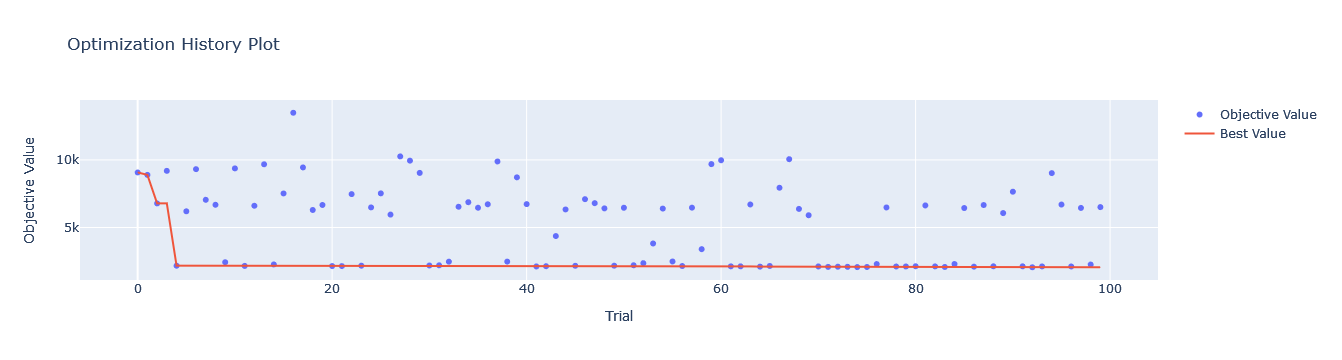

In [47]:
plot_optimization_history(study)

**P2**

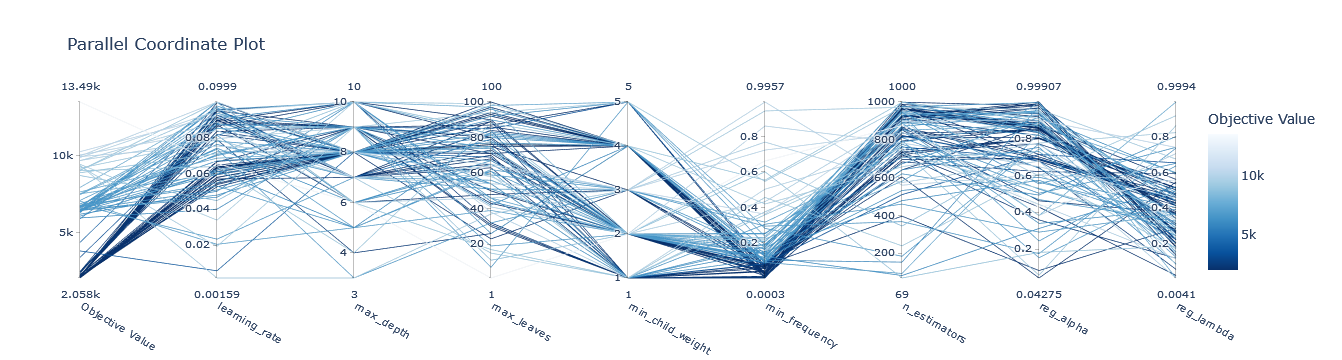

In [49]:
plot_parallel_coordinate(study)

**P3**

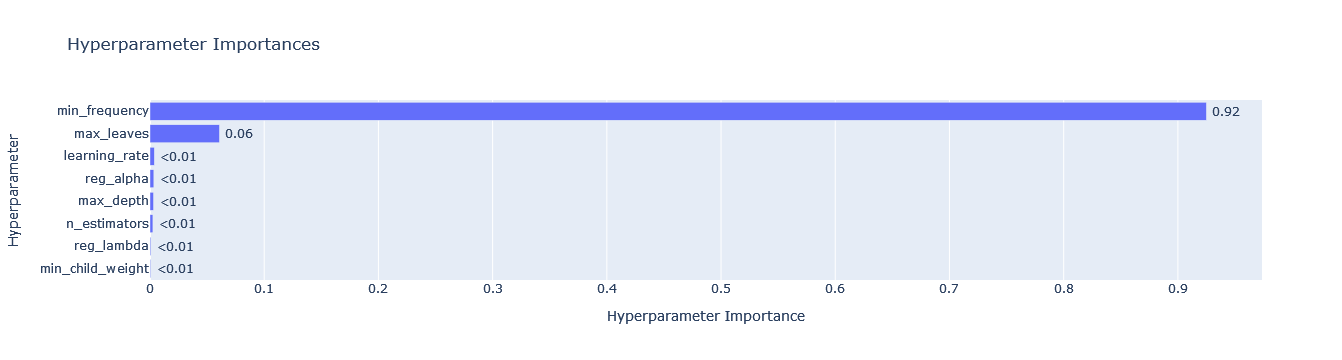

In [51]:
plot_param_importances(study)

**Respuestas**

**P4**

A partir del 4to trial se observan mejoras notables en los resultados, según el gráfico del hitorial de la optimización.


**P5**

Entre las tendencias que se pueden observar del gráfico de coordenadas paralelas, se tiene que el modelo se comporta de mejor manera cuando el *learning rate* es mayor o igual 0.05, el *max depth* es mayoro igual a 7, un *max leaves* mayor a 50, el *min child weight* se comporta de manera uniforme con los valores (no hay una preferencia), un *min frequency* bajo (cercano a 0.0003), *n estimators* mayores a 600, *reg alpha* mayor a 0.6 y un *reg lambda* entre 0.0041 y 0.5.

**P6**

Se observa que claramente los hiperparámetros con mayor relevancia son el *min frequency* y el *max leaves*.

## 6. Síntesis de resultados (0.3)

Finalmente:

1. Genere una tabla resumen del MAE obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning.
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento?
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE.
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

**Respuestas**

**P1**

| Modelo                              |  Valor |
|-------------------------------------|--------|
| Dummy Regressor (Baseline)          | 13.246 |
| XGB Regressor                       | 2.726  |
| XGB Regressor Constrained           | 2.808  |
| XGB Regressor Optimized             | 2.027  |
| XGB Regressor Optimized Pruned      | 2.048  |

**P2**

Se observa que el modelo con mejor rendimiento es el XGB Regressir Optimized Pruned, teniendo un MAE ligeramente menor al XGB Regressor sin podar.

**P3**

In [40]:
best_model = joblib.load('pipeline_xgbregressor_bestparam2.pkl')

In [43]:
y_test_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
print('MAE: ', mae)

MAE:  2088.2778326857824


**P4**

Es ligeramente mayor, lo que sería peor. Esta diferencia es normal y se puede deber a distintos factores, como por ejemplo, diferencias en los set de validación y testeo, donde el primero podría ser más parecido al de entrenamiento que el segundo, generando esta diferencia en los resultados; relacionado tambien a una diferencia en la distribución de los datos entre los sets.


# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>